# Group Details
## Group Name:
### Student 1:
### Student 2:
### Student 3:

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm

In [3]:
# Check if CUDA is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [4]:
TRAIN_1 = False
TRAIN_2 = False
TRAIN_3 = False
GRID_SEARCH_1 = False

In [5]:
def load_trajectory(filename, task):
    """
    This function loads a trajectory from a given file and returns the trajectory and energy data. 
    If the task is 'task_3', it also returns the framework data.

    Parameters:
    filename (str): The name of the file from which to load the trajectory.
    task (str): The task for which the trajectory is being loaded. 
                This should be one of 'task_1', 'task_2', or 'task_3'.

    Returns:
    tuple: Depending on the task, the function returns:
           - (trajectory, energy) for 'task_1' and 'task_2'
           - (trajectory, framework, energy) for 'task_3'
    """
    traj = np.load(filename)
    if task == 'task_1' or task == 'task_2':
        trajectory = traj['trajectory']
        energy = traj['energy']
        return trajectory, energy
    if task == 'task_3':
        trajectory = traj['trajectory']
        framework = traj['framework']
        energy = traj['energy']
        return trajectory, framework, energy

Below, you can find an example of how to load a trajectory. ```trajectory``` contains the particle position, velocity and charge data. ```energy``` contains the energy of the system at various timesteps. The shape of the arrays is as follows:

```trajectory```: ```(time, n_bodies, [x, y, v_x, v_y, q])```

```energy```: ```(time, 1)```

In [6]:
trajectory, energy = load_trajectory('data/task1_2/train/trajectory_0.npz', 'task_1')
print(f'Trajectory shape: {trajectory.shape}, Energy shape: {energy.shape}')

Trajectory shape: (40, 4, 5), Energy shape: (40, 1)


In [7]:
x_0 = trajectory[0][0][0]
y_0 = trajectory[0][0][1]
print(f'Initial position: {x_0}, {y_0} Blue')

Initial position: 9.595544088638388, 7.531951993028981 Blue


The following code provides an example of how to visualize a trajectory. Feel free to modify this code, or write your own function. When evaluating your model in task 2 and 3, keep in mind that you are only allowed to use the data at t=0 (the black dots in the visualization).

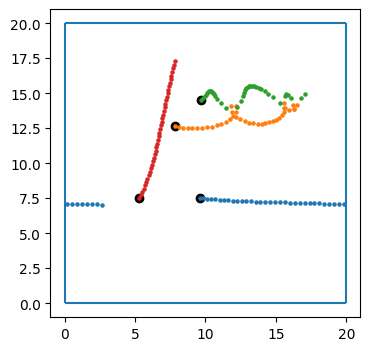

In [8]:
def plot_trajectory(trajectory, energy=None):
    """
    This function plots the trajectory of a system and its energy over time.

    Parameters:
    trajectory (numpy.ndarray): A 2D array representing the trajectory of the system. 
                                The first dimension represents time, and the second dimension represents the x and y coordinates.
    energy (numpy.ndarray): A 1D array representing the energy of the system at each time step.

    The function first plots the trajectory on a 2D grid, with the x and y coordinates on the x and y axes respectively. 
    The initial position is marked in black. The trajectory is represented by a scatter plot, with each point representing the position at a different time step.

    Then, the function plots the energy of the system over time on a separate graph. The x-axis represents the time step, and the y-axis represents the energy.
    """
    
    x = trajectory[...,0]
    y = trajectory[...,1]

    plt.figure(figsize=(4,4))
    plt.vlines([0,20],0,20)
    plt.hlines([0,20],0,20)

    plt.scatter(x[0], y[0], c='black')

    for i in range(x.shape[1]):
        plt.scatter(x[:,i], y[:,i], s=5)

    plt.xlim(-1,21)
    plt.ylim(-1,21)

    plt.show()

    if energy is not None:
        plt.figure(figsize=(4,1))
        plt.plot(energy)
        plt.xlabel('step')
        plt.title('System energy over time')
        plt.show();

plot_trajectory(trajectory)

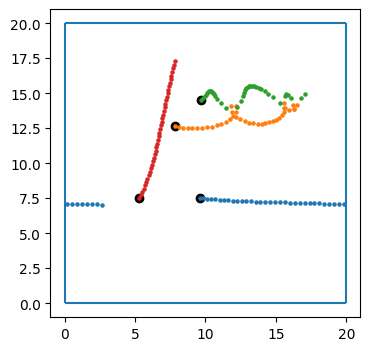

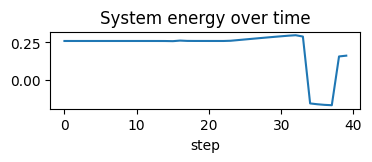

In [9]:
plot_trajectory(trajectory, energy)

# Task 1

Implement task 1 below. Feel free to add extra code cells for different components of your implementation.

## Data Processing

In [10]:
def minimum_image_distance(pos1, pos2, box_length):
    """
    Compute the distance between two points with the minimum image convention.

    Parameters:
    pos1, pos2: numpy arrays representing the positions of the two points.
    box_length: float representing the length of one side of the box.

    Returns:
    float representing the distance between the two points.
    """
    delta = pos2 - pos1
    delta = delta - box_length * np.round(delta / box_length)
    return np.sqrt(np.sum(delta**2))

In [11]:
from torch_geometric.data import Data

def create_graph_from_particles_task_1(particles, energy, box_length=20.0, cutoff_value=10.0):
    """
    This function creates a graph representation of a system of particles for use in graph neural networks. 
    Each particle is represented as a node in the graph, and edges are created between particles that are within a certain cutoff distance of each other.

    Parameters:
    particles (numpy.ndarray): A 2D array representing the particles in the system. 
                               Each row represents a particle, with the first two columns representing the x and y coordinates of the particle, 
                               and the remaining columns representing additional features of the particle.
    energy (float): The energy of the system.
    box_length (float, optional): The length of the box in which the particles are contained. 
                                  This is used to calculate the minimum image distance between particles. Defaults to 20.0.
    cutoff_value (float, optional): The maximum distance at which two particles are considered to be connected by an edge. Defaults to 10.0.

    Returns:
    torch_geometric.data.Data: A Data object representing the graph. 
                               The node features, edge indices, edge attributes, and energy are stored as attributes of this object.

    The function first creates a list of node features and a list of edge indices and attributes. 
    Then, it converts these lists into PyTorch tensors and creates a Data object from them. 
    Finally, it validates the Data object to ensure that it is correctly formatted.
    """

    
    num_particles = particles.shape[0]

    vel = particles[:, 2:4] # Position is not used as node feature
    vel_norm = np.linalg.norm(vel, axis=1)[:, np.newaxis]
    charge = particles[:, 4][:, np.newaxis]

    x = np.concatenate((vel_norm, charge), axis=-1)

    edge_index = []
    edge_attr = []
    for i in range(num_particles):
        for j in range(num_particles):
            if i != j:  # Avoid self-loops

                # Append edge if distance is below cutoff
                pos1 = particles[i, :2]
                pos2 = particles[j, :2]
                distance = minimum_image_distance(pos1, pos2, box_length)
                
                edge_index.append([i, j])
                if distance < cutoff_value: 
                    edge_attr.append(distance)
                else:
                    edge_attr.append(-1.0) # Use -1.0 as padding value

    x = torch.tensor(x, dtype=torch.float)         
    edge_index = torch.tensor(edge_index).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    energy = torch.tensor(energy, dtype=torch.float)

    # Create Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=energy)

    # Validate data object
    data.validate(raise_on_error=True)
    
    return data


def create_particle_data_list_task_1(trajectory, energies, box_length=20.0, cutoff_value=10.0):
    """
    This function creates a list of graph representations of a system of particles for each time step in a trajectory. 
    Each particle is represented as a node in the graph, and edges are created between particles that are within a certain cutoff distance of each other.

    Parameters:
    trajectory (numpy.ndarray): A 3D array representing the trajectory of the system. 
                                The first dimension represents time, the second dimension represents particles, 
                                and the third dimension represents the x and y coordinates of the particles.
    energies (numpy.ndarray): A 1D array representing the energy of the system at each time step.
    box_length (float, optional): The length of the box in which the particles are contained. 
                                  This is used to calculate the minimum image distance between particles. Defaults to 20.0.
    cutoff_value (float, optional): The maximum distance at which two particles are considered to be connected by an edge. Defaults to 10.0.

    Returns:
    list: A list of PyTorch Geometric Data objects, each representing the graph of the system at a different time step.

    The function iterates over each time step in the trajectory, creating a graph for each one and appending it to the list. 
    The graphs are created using the create_graph_from_particles function.
    """
    particle_data_list = []
    for i in range(trajectory.shape[0]):
        particles = trajectory[i]
        energy = energies[i]
        particle_data_list.append(create_graph_from_particles_task_1(particles, energy, box_length, cutoff_value))
    return particle_data_list

particle_data_list = create_particle_data_list_task_1(trajectory, energy)
particles = trajectory[0]
particles_graph = particle_data_list[0]
print(f'Particles ({particles.shape}):\n {particles}')
print(f'Particles graph:\n {particles_graph}')

Particles ((4, 5)):
 [[ 9.59554409  7.53195199  0.51611651 -0.06928145 -1.        ]
 [ 7.84276225 12.65405926  0.5342578  -0.12193773  1.        ]
 [ 9.71213475 14.49577317  0.28795482  0.33377239 -1.        ]
 [ 5.2803654   7.53604669  0.25443658  0.42087594 -1.        ]]
Particles graph:
 Data(x=[4, 2], edge_index=[2, 12], edge_attr=[12], y=[1])


In [12]:
from torch.utils.data import Dataset

class ParticleDataset(Dataset):
    """
    A PyTorch Dataset for representing a system of particles. 
    The dataset is created from a list of file paths, each of which contains a trajectory of the system.

    Attributes:
    file_paths (list): A list of file paths from which to load the trajectories.
    task (str): The task for which the dataset is being created. This should be one of 'task_1', 'task_2', or 'task_3'.
    max_len (int): The maximum number of particles in the system.
    box_length (float, optional): The length of the box in which the particles are contained. Defaults to 20.0.
    cutoff (float, optional): The maximum distance at which two particles are considered to be connected by an edge. Defaults to 10.0.
    data_list (list): A list of PyTorch Geometric Data objects, each representing the graph of the system at a different time step.
    """
    def __init__(self, file_paths, max_len=40, box_length=20.0, cutoff=10.0):
        """
        Initializes the ParticleDataset with the given file paths, task, maximum number of particles, box length, and cutoff distance.
        """
        self.task = 'task_1'
        self.file_paths = file_paths
        self.max_len = max_len
        self.box_length = box_length
        self.cutoff = cutoff
        self.data_list = []
        for file_path in tqdm(file_paths):
            trajectory, energy = load_trajectory(file_path, self.task)
            particle_data_list = create_particle_data_list_task_1(trajectory, energy, self.box_length, self.cutoff)
            self.data_list += particle_data_list
    
    def __len__(self):
        """
        Returns the length of the dataset, i.e., the number of time steps in all trajectories.
        """
        return len(self.data_list)
    
    def __getitem__(self, idx):
        """
        Returns the Data object at the given index.
        """
        return self.data_list[idx]
    


In [13]:
from sklearn.model_selection import train_test_split
import glob
import os
import pickle

# Define the paths and parameters
file_paths = glob.glob('data/task1_2/train/*.npz')

max_len = 40  # The maximum length of the trajectories is 40
box_length = 20.0  # The length of the simulation box
cutoff = 10.0  # The cutoff distance for the edges
task = 'task_1'  # The task to perform

train_paths_task_1, val_paths_task_1 = train_test_split(file_paths, test_size=0.2, random_state=42)

train_dataset_task_1 = ParticleDataset(train_paths_task_1, max_len, box_length, cutoff)
val_dataset_task_1 = ParticleDataset(val_paths_task_1, max_len, box_length, cutoff)

print(f'Train dataset: {len(train_dataset_task_1)} samples')
print(f'Validation dataset: {len(val_dataset_task_1)} samples')

100%|██████████| 180/180 [00:01<00:00, 177.82it/s]

Train dataset: 28800 samples
Validation dataset: 7200 samples


In [14]:
train_dataset_task_1[0]

Data(x=[3, 2], edge_index=[2, 6], edge_attr=[6], y=[1])

In [15]:
from torch_geometric.loader import DataLoader

batch_size = 1  # The batch size

# Create data loaders
train_loader_task_1 = DataLoader(train_dataset_task_1, batch_size=batch_size, shuffle=True)
val_loader_task_1 = DataLoader(val_dataset_task_1, batch_size=batch_size, shuffle=False)

for data in train_loader_task_1:
    print(data)
    break

DataBatch(x=[3, 2], edge_index=[2, 6], edge_attr=[6], y=[1], batch=[3], ptr=[2])


## Model Definition

In [16]:
import torch.nn as nn

class Node_to_emb(nn.Module):
    """
    This class is a PyTorch module that transforms node features into node embeddings using a linear transformation.

    Attributes:
    emb (nn.Linear): A linear transformation layer.
    """
    def __init__(self, node_feat_dim=2, node_emb_dim=64):
        """
        Initializes the Node_to_emb with the given dimensions for the node features and node embeddings.
        """
        super(Node_to_emb, self).__init__()
        self.emb = nn.Linear(node_feat_dim, node_emb_dim)

    def forward(self, nodes):
        """
        Transforms the given node features into node embeddings using the linear transformation layer.
        """
        assert nodes.size(-1) == self.emb.in_features, 'wrong input dimension of node features!'
        return self.emb(nodes)

class MpLayer(nn.Module):
    """
    This class is a PyTorch module that represents a message passing layer in a graph neural network.

    Attributes:
    edge_network (nn.Sequential): A sequence of layers that transform the edge features.
    node_network (nn.Sequential): A sequence of layers that transform the node features.
    """
    def __init__(self, hidden_dim, activation=nn.ReLU()):
        """
        Initializes the MpLayer with the given hidden dimension and activation function.
        """
        super(MpLayer, self).__init__()
        self.edge_network = nn.Sequential(
            nn.Linear(2*hidden_dim + 1, hidden_dim), # +1 for edge_attr
            activation,
            nn.Linear(hidden_dim, hidden_dim),
            activation
        )
        self.node_network = nn.Sequential(
            nn.Linear(2*hidden_dim, hidden_dim),
            activation,
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, node_tensor, edge_idx_tensor, edge_attr_tensor):
        """
        Performs the forward pass of the message passing layer.
        """
        edge_messages_input = torch.cat([node_tensor[edge_idx_tensor[0,:]], node_tensor[edge_idx_tensor[1,:]]], dim=-1)
        
        edge_attr_tensor = edge_attr_tensor.unsqueeze(-1)
        edge_messages_input = torch.cat([edge_messages_input, edge_attr_tensor], dim=-1)
    
        edge_messages_output = self.edge_network(edge_messages_input)
        
        node_agg_messages = torch.zeros_like(node_tensor).to(node_tensor.device)
        node_agg_messages = node_agg_messages.scatter_add_(
            dim=0, index=edge_idx_tensor[1].unsqueeze(-1).expand(-1, node_tensor.size(1)), src=edge_messages_output
        )
        
        node_out = self.node_network(torch.cat([node_tensor, node_agg_messages], dim=-1))
        return node_out, edge_idx_tensor

class MpGNN(nn.Module):
    """
    This class is a PyTorch module that represents a message passing graph neural network.

    Attributes:
    node_to_emb (Node_to_emb): A module that transforms node features into node embeddings.
    mp_layers (nn.ModuleList): A list of message passing layers.
    to_pred (nn.Linear): A linear transformation layer that transforms the output of the last message passing layer into the final output.
    """
    def __init__(self, node_feat_dim, hidden_dim, activation=nn.ReLU(), num_layers=3):
        """
        Initializes the MpGNN with the given dimensions for the node features and hidden layer, activation function, and number of layers.
        """
        super(MpGNN, self).__init__()
        self.node_to_emb = Node_to_emb(node_feat_dim, hidden_dim)
        self.mp_layers = nn.ModuleList([MpLayer(hidden_dim, activation) for _ in range(num_layers)])
        self.to_pred = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index, edge_attr, batch):
        """
        Performs the forward pass of the graph neural network.
        """
        x = self.node_to_emb(x)
        for layer in self.mp_layers:
            x, edge_index = layer(x, edge_index, edge_attr)
        
        out = torch.zeros(batch.max().item() + 1, x.size(1)).to(x.device)
        idx_aggregate_graph = batch.unsqueeze(-1).expand_as(x)
        out.scatter_add_(dim=0, index=idx_aggregate_graph, src=x)
        
        out = self.to_pred(out)
        return out

In [17]:
num_features = int(train_dataset_task_1[0].x.shape[1])
num_features

2

In [18]:
from torch.optim import Adam

# Hyperparameters
hidden_dim = 256
num_layers = 5
learning_rate = 0.0001
weight_decay = 0
num_epochs = 40
# Initialize the model, optimizer and loss function
model_task_1 = MpGNN(num_features, hidden_dim=hidden_dim, num_layers=num_layers) # initialize  GNN

optimizer = Adam(model_task_1.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.MSELoss()

model_task_1.to(device)  # move to the GPU, if possible

MpGNN(
  (node_to_emb): Node_to_emb(
    (emb): Linear(in_features=2, out_features=256, bias=True)
  )
  (mp_layers): ModuleList(
    (0-4): 5 x MpLayer(
      (edge_network): Sequential(
        (0): Linear(in_features=513, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): ReLU()
      )
      (node_network): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
      )
    )
  )
  (to_pred): Linear(in_features=256, out_features=1, bias=True)
)

In [19]:
# Test forward pass
batch_1 = next(iter(train_loader_task_1))
output = model_task_1(batch_1.x.to(device), batch_1.edge_index.to(device), batch_1.edge_attr.to(device), batch_1.batch.to(device))
print(f'Output shape: {output}')

Output shape: tensor([[-0.1560]], grad_fn=<AddmmBackward0>)


## Training

In [20]:
def train(model, train_loader, optimizer, criterion, device):
    """
    This function trains the given model for one epoch using the given data loader, optimizer, loss function, and device.

    Parameters:
    model (torch.nn.Module): The model to train.
    train_loader (torch.utils.data.DataLoader): The data loader that provides the training data.
    optimizer (torch.optim.Optimizer): The optimizer to use for training.
    criterion (torch.nn.Module): The loss function to use for training.
    device (torch.device): The device to use for training.

    The function first sets the model to training mode. Then, it iterates over the training data. For each batch of data, 
    it moves the data to the given device, performs a forward pass, computes the loss, performs a backward pass, 
    and updates the model parameters. The function keeps track of the total loss over all batches. 
    Finally, it returns the average loss over all batches.
    """
    progress_bar = tqdm(train_loader, desc='Training', dynamic_ncols=True, leave=False)
    model.train()
    total_loss = 0
    for data in progress_bar:
        
        data = data.to(device)
        optimizer.zero_grad()
        
        output = model(data.x, data.edge_index, data.edge_attr, data.batch)
       
        loss = criterion(output, data.y.view(-1, 1))  # y is a single value per graph
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    progress_bar.close()
    return total_loss / len(train_loader)


def validate(model, val_loader, criterion, device):
    """
    This function validates the given model using the given data loader, loss function, and device.

    Parameters:
    model (torch.nn.Module): The model to validate.
    val_loader (torch.utils.data.DataLoader): The data loader that provides the validation data.
    criterion (torch.nn.Module): The loss function to use for validation.
    device (torch.device): The device to use for validation.

    The function first sets the model to evaluation mode. Then, it iterates over the validation data. 
    For each batch of data, it moves the data to the given device, performs a forward pass, and computes the loss. 
    The function keeps track of the total loss over all batches. 
    Finally, it returns the average loss over all batches.
    """
    
    progress_bar = tqdm(val_loader, desc='Validating', dynamic_ncols=True, leave=False)

    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in progress_bar:
            data = data.to(device)
            output = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(output, data.y.view(-1, 1))  # y is a single value per graph
            total_loss += loss.item()
    
    progress_bar.close()
    return total_loss / len(val_loader)

# Train model
if TRAIN_1:
    train_losses = []
    val_losses = []

    # Initialize best validation loss to infinity
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        train_loss = train(model_task_1, train_loader_task_1, optimizer, criterion, device)
        train_losses.append(train_loss)
        val_loss = validate(model_task_1, val_loader_task_1, criterion, device)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        # Save the model if it's the best one so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model_task_1.state_dict(), 'best_model_task_1.pth')

    print(f'Best Val Loss: {best_val_loss}')


In [21]:
# Plot the training and validation losses
def plot_losses(train_losses, val_losses):
    """
    This function plots the training and validation losses over epochs.

    Parameters:
    train_losses (list): A list of training losses for each epoch.
    val_losses (list): A list of validation losses for each epoch.

    The function uses matplotlib to create a line plot of the training and validation losses. 
    The x-axis represents the epoch number and the y-axis represents the loss. 
    The training losses are plotted in one color and the validation losses are plotted in another color. 
    A legend is added to the plot to distinguish between the two lines. 
    Finally, the plot is displayed.
    """
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

if TRAIN_1:
    plot_losses(train_losses, val_losses)

## Test

In [22]:
# Load the best model
model_task_1 = MpGNN(num_features, hidden_dim=hidden_dim, num_layers=num_layers)
model_task_1.load_state_dict(torch.load('best_model_task_1.pth'))

<All keys matched successfully>

In [23]:
# Load and preprocess test data
test_file_paths_task_1 = glob.glob('data/task1_2/test/*.npz')

test_dataset_task_1 = ParticleDataset(test_file_paths_task_1, max_len, box_length, cutoff)
test_loader_task_1 = DataLoader(test_dataset_task_1, batch_size=batch_size, shuffle=False)

100%|██████████| 100/100 [00:00<00:00, 170.92it/s]


In [24]:
print(f'Test dataset: {len(test_dataset_task_1)} samples')

Test dataset: 4000 samples


In [25]:
def compute_test_loss(model, test_loader, criterion ):
    """
    This function computes the loss of the given model on the given test data using the given loss function.

    Parameters:
    model (torch.nn.Module): The model to test.
    test_loader (torch.utils.data.DataLoader): The data loader that provides the test data.
    criterion (torch.nn.Module): The loss function to use for testing.

    The function first sets the model to evaluation mode. Then, it iterates over the test data. 
    For each batch of data, it moves the data to the device, performs a forward pass, and computes the loss. 
    The function keeps track of the total loss over all batches. Finally, it returns the average loss over all batches.
    """
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            output = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(output, data.y.view(-1, 1))  # y is a single value per graph
            total_loss += loss.item()
    return total_loss / len(test_loader)

train_loss = compute_test_loss(model_task_1, train_loader_task_1, criterion)
print(f'Train Loss: {train_loss}')
val_loss = compute_test_loss(model_task_1, val_loader_task_1, criterion)
print(f'Validation Loss: {val_loss}')
test_loss = compute_test_loss(model_task_1, test_loader_task_1, criterion)
print(f'Test Loss: {test_loss}')


Train Loss: 0.7365007206539506
Validation Loss: 0.12955530894838446
Test Loss: 0.07150567370000245


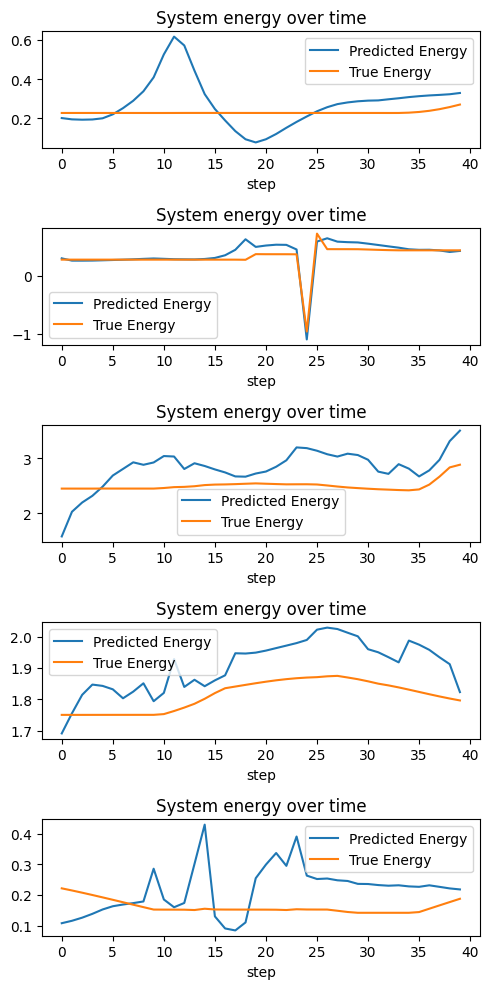

In [26]:
from torch_geometric.data import Batch

def plot_predictions(model, file_paths, device, task, num_plots=5, box_length=20.0, cutoff_value=10.0):
    """
    This function plots the predicted and true energies over time for a random selection of systems from the given file paths.

    Parameters:
    model (torch.nn.Module): The model to use for prediction.
    file_paths (list): A list of file paths to the system data.
    device (torch.device): The device to use for prediction.
    task (str): The task to perform (e.g., 'classification', 'regression').
    num_plots (int, optional): The number of plots to create. Default is 5.
    box_length (float, optional): The length of the box in which the particles are contained. Default is 20.0.
    cutoff_value (float, optional): The cutoff value for the interaction between particles. Default is 10.0.

    The function first sets the model to evaluation mode. Then, it selects a random subset of the file paths. 
    For each selected file path, it loads the system data, creates a graph from the system data, 
    and uses the model to predict the energies of the system over time. 
    It then plots the predicted energies and the true energies on the same plot. 
    The x-axis represents the time step and the y-axis represents the energy. 
    A legend is added to the plot to distinguish between the predicted and true energies. 
    Finally, the function displays all the plots.
    """
    model.eval()
    random_indices = np.random.randint(0, len(file_paths), size=num_plots)
    random_paths = [file_paths[i] for i in random_indices]

    fig, axs = plt.subplots(num_plots, 1, figsize=(5, num_plots*2))

    with torch.no_grad():
        plot_count = 0
        for i, path in enumerate(random_paths):
            
            trajectory, energy = load_trajectory(path, task)
           
            # Create a graph from the trajectory
            particles_list = create_particle_data_list_task_1(trajectory, energy, box_length, cutoff_value)
            batched_data = Batch.from_data_list(particles_list).to(device)

            output = model(batched_data.x, batched_data.edge_index, batched_data.edge_attr, batched_data.batch)

            # Plot predicted energies
            axs[plot_count].plot(output.cpu(), label='Predicted Energy')

            # Plot true energies
            axs[plot_count].plot(energy.flatten(), label='True Energy')

            axs[plot_count].set_xlabel('step')
            axs[plot_count].set_title('System energy over time')
            axs[plot_count].legend()

            
            plot_count += 1
            if plot_count == num_plots:
                break

    plt.tight_layout()
    plt.show()

plot_predictions(model_task_1, test_file_paths_task_1, device, task)


## Tuning

In [27]:
import itertools

def grid_search(train_loader, val_loader, num_features, num_epochs, device, output_file):
    """
    This function performs a grid search over a set of hyperparameters to find the best model for the given training and validation data.

    Parameters:
    train_loader (torch.utils.data.DataLoader): The data loader that provides the training data.
    val_loader (torch.utils.data.DataLoader): The data loader that provides the validation data.
    num_features (int): The number of features in the input data.
    num_epochs (int): The number of epochs to train each model.
    device (torch.device): The device to use for training and validation.
    output_file (str): The path to the file where the grid search results will be written.

    The function iterates over all combinations of the hyperparameters. For each combination, it creates a model with the current hyperparameters, 
    trains the model for the given number of epochs, and computes the validation loss. 
    If the validation loss is lower than the best validation loss seen so far, the function updates the best model, best validation loss, and best hyperparameters. 
    The function writes the hyperparameters and validation loss of each model to the output file. 
    Finally, the function returns the best model, best hyperparameters, and best validation loss.
    """
    
    # Define hyperparameters to tune
    hidden_dims = [32, 64, 128, 256]
    num_layers_list = [5, 7, 9]
    learning_rates = [0.0001, 0.001]
    weight_decays = [0.0, 1e-5]

    best_model = None
    best_val_loss = float('inf')
    best_params = {}

    with open(output_file, 'w') as f:
        f.write("hidden_dim,num_layers,lr,weight_decay,val_loss\n")

        for hidden_dim, num_layers, lr, weight_decay in tqdm(itertools.product(hidden_dims, num_layers_list, learning_rates, weight_decays)):
            # Create model with current hyperparameters
            model = MpGNN(num_features, hidden_dim=hidden_dim, num_layers=num_layers) # initialize our GNN
            # Define optimizer and criterion
            optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            criterion = torch.nn.MSELoss()

            best_model_loss = float('inf')

            # Train model
            print(f'Starting training with hidden_dim={hidden_dim}, num_layers={num_layers}, lr={lr}, weight_decay={weight_decay}')
            for epoch in range(num_epochs):
                train_loss = train(model, train_loader, optimizer,criterion, device)
                val_loss = validate(model, val_loader, criterion, device)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model
                    best_params = {'hidden_dim': hidden_dim, 'num_layers': num_layers, 'lr': lr, 'weight_decay': weight_decay}
                    torch.save(best_model.state_dict(), 'best_model_grid_search.pth')

                if val_loss < best_model_loss:
                    best_model_loss = val_loss

            f.write(f"{hidden_dim},{num_layers},{lr},{weight_decay},{best_model_loss}\n")
            print(f"Finished training with hidden_dim={hidden_dim}, num_layers={num_layers}, lr={lr}, weight_decay={weight_decay}, val_loss={best_model_loss}")
     
    return best_model, best_params, best_val_loss


num_epochs = 20

if GRID_SEARCH_1:
    output_file = "grid_search_results_task_1.txt"
    best_model_task_1, best_params, best_val_loss = grid_search(train_loader_task_1, val_loader_task_1, num_features, num_epochs, device, output_file)
    torch.save(best_model_task_1.state_dict(), 'best_model_grid_search_task_1.pth')
    print("Best Parameters:")
    print(best_params)
    print("Best Validation Loss:", best_val_loss)

Best Parameters: {'hidden_dim': 64, 'num_layers': 7, 'lr': 0.0001, 'weight_decay': 0}

Best Validation Loss: 0.215618465204782

# Task 2

Implement task 2 below. Feel free to add extra code cells for different components of your implementation.

## Preprocessing

In [28]:
from torch_geometric.data import Data

def convert_to_polar_coordinates(velocity_x, velocity_y):
    """
    This function converts the x and y components of the velocity of a particle into polar coordinates.

    Parameters:
    velocity_x (torch.Tensor): A tensor representing the x component of the velocity.
    velocity_y (torch.Tensor): A tensor representing the y component of the velocity.

    Returns:
    torch.Tensor: A tensor representing the magnitude and angle of the velocity in polar coordinates.

    The function first computes the magnitude of the velocity using the Pythagorean theorem. 
    Then, it computes the angle of the velocity using the arctangent function. 
    The function returns a tensor containing the magnitude and angle of the velocity.
    """
    magnitude = np.sqrt(velocity_x**2 + velocity_y**2)
    angle = np.arctan2(velocity_y, velocity_x)
    return np.stack([magnitude, angle], axis=-1)

def create_graph_from_particles_task_2(particles, next_particles=None, energy=0.0, box_length=20.0, cutoff_value=10.0):
    """
    This function creates a graph representation of a system of particles for use in graph neural networks. 
    Each particle is represented as a node in the graph, and edges are created between particles that are within a certain cutoff distance of each other.

    Parameters:
    particles (numpy.ndarray): A 2D array representing the particles in the system. 
                               Each row represents a particle, with the first two columns representing the x and y coordinates of the particle, 
                               and the remaining columns representing additional features of the particle.
    energy (float): The energy of the system.
    box_length (float, optional): The length of the box in which the particles are contained. 
                                  This is used to calculate the minimum image distance between particles. Defaults to 20.0.
    cutoff_value (float, optional): The maximum distance at which two particles are considered to be connected by an edge. Defaults to 10.0.

    Returns:
    torch_geometric.data.Data: A Data object representing the graph. 
                               The node features, edge indices, edge attributes, and energy are stored as attributes of this object.

    The function first creates a list of node features and a list of edge indices and attributes. 
    Then, it converts these lists into PyTorch tensors and creates a Data object from them. 
    Finally, it validates the Data object to ensure that it is correctly formatted.
    """
    
    num_particles = particles.shape[0]

    velocity_x = particles[:, 2]
    velocity_y = particles[:, 3]
    charge = particles[:, 4][:, np.newaxis]
    
    pol_coords = convert_to_polar_coordinates(velocity_x, velocity_y)
    norm = pol_coords[:, 0][:, np.newaxis]
    angle = pol_coords[:, 1][:, np.newaxis]

    # Use sine and cosine of the angle
    sin_angle = np.sin(angle)
    cos_angle = np.cos(angle)

    # Create energy vector to be used as node feature
    energy = np.array([energy] * num_particles)
   

    x = np.concatenate((norm, sin_angle, cos_angle, charge, energy), axis=-1)

    edge_index = []
    edge_attr = []
    for i in range(num_particles):
        for j in range(num_particles):
            if i != j:  # Avoid self-loops

                # Append edge if distance is below cutoff
                pos1 = particles[i, :2]
                pos2 = particles[j, :2]
                distance = minimum_image_distance(pos1, pos2, box_length)
                
                edge_index.append([i, j])
                if distance < cutoff_value: 
                    edge_attr.append(distance)
                else:
                    edge_attr.append(-1.0) # Use -1.0 as padding value

    x = torch.tensor(x, dtype=torch.float)
    edge_index = torch.tensor(edge_index).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
   

    if next_particles is not None: # For training, set target y in Data object
        next_velocity_x = next_particles[:, 2]
        next_velocity_y = next_particles[:, 3]


        next_polar_coords = convert_to_polar_coordinates(next_velocity_x, next_velocity_y)
        next_norm = next_polar_coords[:, 0][:, np.newaxis]
        next_angle = next_polar_coords[:, 1][:, np.newaxis]

        next_sin_angle = np.sin(next_angle)
        next_cos_angle = np.cos(next_angle)

        target = np.concatenate((next_norm, next_sin_angle, next_cos_angle), axis=-1)
        target = torch.tensor(target, dtype=torch.float) # Use next velocity as target


        # Create Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=target)

    else: # For testing, do not set target y in Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

    # Validate data object
    data.validate(raise_on_error=True)
    
    return data


def create_particle_data_list_task_2(trajectory, energies, box_length=20.0, cutoff_value=10.0):
    """
    This function creates a list of graph representations of a system of particles for each time step in a trajectory. 
    Each particle is represented as a node in the graph, and edges are created between particles that are within a certain cutoff distance of each other.

    Parameters:
    trajectory (numpy.ndarray): A 3D array representing the trajectory of the system. 
                                The first dimension represents time, the second dimension represents particles, 
                                and the third dimension represents the x and y coordinates of the particles.
    energies (numpy.ndarray): A 1D array representing the energy of the system at each time step.
    box_length (float, optional): The length of the box in which the particles are contained. 
                                  This is used to calculate the minimum image distance between particles. Defaults to 20.0.
    cutoff_value (float, optional): The maximum distance at which two particles are considered to be connected by an edge. Defaults to 10.0.

    Returns:
    list: A list of PyTorch Geometric Data objects, each representing the graph of the system at a different time step.

    The function iterates over each time step in the trajectory, creating a graph for each one and appending it to the list. 
    The graphs are created using the create_graph_from_particles function.
    """
    particle_data_list = []
    for i in range(trajectory.shape[0] - 1):
        particles = trajectory[i]
        next_particles = trajectory[i+1]
        energy = energies[i]
        particle_data_list.append(create_graph_from_particles_task_2(particles, next_particles, energy, box_length, cutoff_value))
    
    assert (trajectory.shape[0]-1) == len(particle_data_list)
    return particle_data_list


# Test the functions on the first trajectory

trajectory, energy = load_trajectory('data/task1_2/train/trajectory_0.npz', 'task_2')

print(f'Trajectory shape: {trajectory.shape}, Energy shape: {energy.shape}')
particle_data_list = create_particle_data_list_task_2(trajectory, energy)

particles = trajectory[0]
energy = energy[0]
next_particles = trajectory[1]
print(f'Particles ({particles.shape}):\n {particles}')
print(f'Energy: {energy}')
print(f'Next Particles ({next_particles.shape}):\n {next_particles}')

particles_graph = particle_data_list[0]
print(f'Particles graph x:\n {particles_graph.x}')
print(f'Particles graph y (next):\n {particles_graph.y}')


Trajectory shape: (40, 4, 5), Energy shape: (40, 1)
Particles ((4, 5)):
 [[ 9.59554409  7.53195199  0.51611651 -0.06928145 -1.        ]
 [ 7.84276225 12.65405926  0.5342578  -0.12193773  1.        ]
 [ 9.71213475 14.49577317  0.28795482  0.33377239 -1.        ]
 [ 5.2803654   7.53604669  0.25443658  0.42087594 -1.        ]]
Energy: [0.25985556]
Next Particles ((4, 5)):
 [[ 9.85877038  7.49870635  0.53647451 -0.06382443 -1.        ]
 [ 8.12182376 12.59852055  0.58054579 -0.09997886  1.        ]
 [ 9.84478862 14.65379992  0.24390343  0.29793727 -1.        ]
 [ 5.40180659  7.74851886  0.23184199  0.42929516 -1.        ]]
Particles graph x:
 tensor([[ 0.5207, -0.1330,  0.9911, -1.0000,  0.2599],
        [ 0.5480, -0.2225,  0.9749,  1.0000,  0.2599],
        [ 0.4408,  0.7572,  0.6532, -1.0000,  0.2599],
        [ 0.4918,  0.8558,  0.5174, -1.0000,  0.2599]])
Particles graph y (next):
 tensor([[ 0.5403, -0.1181,  0.9930],
        [ 0.5891, -0.1697,  0.9855],
        [ 0.3850,  0.7738,  0.63

In [29]:
import math

def rotate_graph(data, angle_degrees):
    """
    Rotates the graph by a given angle in degrees.

    Args:
        data (Data): A PyTorch Geometric Data object containing node features, edge index, and edge attributes.
        angle_degrees (float): The angle by which to rotate the graph, in degrees.

    Returns:
        Data: A PyTorch Geometric Data object containing the rotated node features, edge index, and edge attributes.
    """
    node_features = data.x
    edge_index = data.edge_index
    edge_attr = data.edge_attr

    rotated_features = node_features.clone()

    # Convert angle from degrees to radians
    angle_radians = math.radians(angle_degrees)

    # Extract norm, sin, cos, charge
    norm = node_features[:, 0]
    sin = node_features[:, 1]
    cos = node_features[:, 2]
    charge = node_features[:, 3]
    energy = node_features[:, 4]

    # Calculate the new sin and cos using the rotation matrix
    new_sin = sin * math.cos(angle_radians) - cos * math.sin(angle_radians)
    new_cos = sin * math.sin(angle_radians) + cos * math.cos(angle_radians)

    # Update the rotated features
    rotated_features[:, 0] = norm
    rotated_features[:, 1] = new_sin
    rotated_features[:, 2] = new_cos
    rotated_features[:, 3] = charge
    rotated_features[:, 4] = energy

    # Edge attributes remain the same
    rotated_edge_attr = edge_attr.clone()

    # Create and return a new Data object with the rotated features
    rotated_data = Data(x=rotated_features, edge_index=edge_index, edge_attr=rotated_edge_attr)

    return rotated_data

def rotate_target(target, angle_degrees):
    """
    Rotates the target tensor by a given angle in degrees.

    Args:
        target (torch.Tensor): A tensor of shape (num_nodes, 3) containing [norm, sin, cos] for each node.
        angle_degrees (float): The angle by which to rotate the target tensor, in degrees.

    Returns:
        torch.Tensor: A tensor of shape (num_nodes, 3) with the rotated [norm, sin, cos] values.
    """
    rotated_target = target.clone()

    # Convert angle from degrees to radians
    angle_radians = math.radians(angle_degrees)

    # Extract norm, sin, cos
    norm = target[:, 0]
    sin = target[:, 1]
    cos = target[:, 2]

    # Calculate the new sin and cos using the rotation matrix
    new_sin = sin * math.cos(angle_radians) - cos * math.sin(angle_radians)
    new_cos = sin * math.sin(angle_radians) + cos * math.cos(angle_radians)

    # Update the rotated target tensor
    rotated_target[:, 0] = norm
    rotated_target[:, 1] = new_sin
    rotated_target[:, 2] = new_cos

    return rotated_target

In [30]:
class ParticleDynamicsDataset():
    def __init__(self, file_paths, max_len=40, box_length=20.0, cutoff=10.0):
        """
        The ParticleDynamicsDataset class is used to represent a dataset of particle dynamics. 
        It is initialized with a list of file paths, each of which points to a file containing data for a single trajectory of particles. 
        The class also takes parameters for the maximum number of particles (`max_len`), 
        the length of the box in which the particles are contained (`box_length`), 
        and the cutoff distance for interactions between particles (`cutoff`).
        """
        self.file_paths = file_paths
        self.max_len = max_len
        self.box_length = box_length
        self.task = "task_2"
        self.cutoff = cutoff
        self.data_list = []
        self.augmented = False

        for file_path in tqdm(file_paths, desc="Loading data"):
            trajectory, energy = load_trajectory(file_path, self.task)
            particle_data_list = create_particle_data_list_task_2(trajectory, energy, self.box_length, self.cutoff)
        
            self.data_list += particle_data_list
    
    def __len__(self):
        """
        Returns the length of the dataset, i.e., the number of time steps in all trajectories.
        """
        return len(self.data_list)
    
    def __getitem__(self, idx):
        """
        Returns the Data object at the given index.
        """
        return self.data_list[idx]

    def augment_data(self, rotation_step=10):
        """
        Augments the dataset by rotating the graphs and targets.

        Returns:
        list: A list of PyTorch Geometric Data objects with the augmented graphs.
        """
        if self.augmented:
            print("Data already augmented")
            return
        
        self.augmented = True
        augmented_data = []

        for data in tqdm(self.data_list, desc="Augmenting data"):
            angles = [i for i in range(1, 360, rotation_step)]
            for angle in angles:
                rotated_data = rotate_graph(data, angle)
                rotated_target = rotate_target(data.y, angle)
                rotated_data.y = rotated_target
                augmented_data.append(rotated_data)
        
        self.data_list += augmented_data

In [31]:
from sklearn.model_selection import train_test_split
import glob
import pickle
import os

# Define the paths and parameters
file_paths = glob.glob('data/task1_2/train/*.npz')

max_len = 40  # The maximum length of the trajectories is 40
box_length = 20.0  # The length of the simulation box
cutoff = 10.0  # The cutoff distance for the edges
task = 'task_2'  # The task to perform


train_paths_task_2, val_paths_task_2 = train_test_split(file_paths, test_size=0.2, random_state=42)

train_dataset_task_2 = ParticleDynamicsDataset(train_paths_task_2, max_len, box_length, cutoff)
val_dataset_task_2 = ParticleDynamicsDataset(val_paths_task_2, max_len, box_length, cutoff)

# Augment the training dataset
train_dataset_task_2.augment_data(5)

print(f'Train dataset: {len(train_dataset_task_2)} samples')
print(f'Validation dataset: {len(val_dataset_task_2)} samples')

Loading data: 100%|██████████| 180/180 [00:01<00:00, 162.49it/s]

Train dataset: 28080 samples
Validation dataset: 7020 samples


In [32]:
# Example of a data object in the dataset
train_dataset_task_2[0].x, train_dataset_task_2[0].y

(tensor([[ 4.5439e-01,  7.1372e-01, -7.0043e-01, -1.0000e+00, -5.5995e-03],
         [ 5.4554e-01,  1.0000e+00,  3.5470e-05,  1.0000e+00, -5.5995e-03],
         [ 4.8423e-01, -8.5299e-01,  5.2192e-01,  1.0000e+00, -5.5995e-03]]),
 tensor([[ 0.4121,  0.6292, -0.7773],
         [ 0.5994,  0.9999,  0.0103],
         [ 0.4725, -0.8504,  0.5261]]))

In [33]:
from torch_geometric.loader import DataLoader

batch_size = 32  # The batch size

# Create data loaders
train_loader_task_2 = DataLoader(train_dataset_task_2, batch_size=batch_size, shuffle=True)
val_loader_task_2 = DataLoader(val_dataset_task_2, batch_size=batch_size, shuffle=False)

for data in train_loader_task_2:
    print(data)
    break

DataBatch(x=[126, 5], edge_index=[2, 388], edge_attr=[388], y=[126, 3], batch=[126], ptr=[33])


## Model Definition

In [34]:
num_features = int(train_dataset_task_2[0].x.shape[1])
print(f"Num features: {num_features}")
num_targets = int(train_dataset_task_2[0].y.shape[1])
print(f"Num targets: {num_targets}")

Num features: 5
Num targets: 3


In [35]:
class MpGNN_task_2(nn.Module):
    """
    This class is a PyTorch module that represents a message passing graph neural network.

    Attributes:
    node_to_emb (Node_to_emb): A module that transforms node features into node embeddings.
    mp_layers (nn.ModuleList): A list of message passing layers.
    to_pred (nn.Linear): A linear transformation layer that transforms the output of the last message passing layer into the final output.
    """
    def __init__(self, node_feat_dim, hidden_dim, output_dim, activation=nn.ReLU(), num_layers=3):
        super(MpGNN_task_2, self).__init__()
        self.node_to_emb = Node_to_emb(node_feat_dim, hidden_dim)
        self.mp_layers = nn.ModuleList([MpLayer(hidden_dim, activation) for _ in range(num_layers)])
        
        # Linear layer to map hidden_dim to output_dim
        self.to_pred = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_attr, batch=None):
        """
        Performs the forward pass of the graph neural network.
        """
        x = self.node_to_emb(x)
        for layer in self.mp_layers:
            x, edge_index = layer(x, edge_index, edge_attr)
        
        out = self.to_pred(x)  # (num_nodes, output_dim)
        
        return out

In [36]:
from torch.optim import Adam
from torch_geometric.nn import summary

# Hyperparameters
hidden_dim = 64
num_layers = 5
learning_rate = 0.00005
weight_decay = 0
num_epochs = 25

# Initialize the model, optimizer and loss function
model_task_2 = MpGNN_task_2(node_feat_dim=num_features, output_dim=num_targets, hidden_dim=hidden_dim, num_layers=num_layers) # initialize our GNN

optimizer = Adam(model_task_2.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.MSELoss()

model_task_2.to(device)  # and move to the GPU, if possible
dummy_data = next(iter(train_loader_task_2))
print(summary(model_task_2, dummy_data.x, dummy_data.edge_index, dummy_data.edge_attr, dummy_data.batch))

+--------------------------------------+----------------------------------+---------------------+----------+
| Layer                                | Input Shape                      | Output Shape        | #Param   |
|--------------------------------------+----------------------------------+---------------------+----------|
| MpGNN_task_2                         | [126, 5], [2, 390], [390], [126] | [126, 3]            | 125,059  |
| ├─(node_to_emb)Node_to_emb           | [126, 5]                         | [126, 64]           | 384      |
| │    └─(emb)Linear                   | [126, 5]                         | [126, 64]           | 384      |
| ├─(mp_layers)ModuleList              | --                               | --                  | 124,480  |
| │    └─(0)MpLayer                    | [126, 64], [2, 390], [390]       | [126, 64], [2, 390] | 24,896   |
| │    │    └─(edge_network)Sequential | [390, 129]                       | [390, 64]           | 12,480   |
| │    │    └─(node

## Training

In [37]:
def train(model, train_loader, optimizer, criterion, device):
    """
    This function trains the given model for one epoch using the given data loader, optimizer, loss function, and device.

    Parameters:
    model (torch.nn.Module): The model to train.
    train_loader (torch.utils.data.DataLoader): The data loader that provides the training data.
    optimizer (torch.optim.Optimizer): The optimizer to use for training.
    criterion (torch.nn.Module): The loss function to use for training.
    device (torch.device): The device to use for training.

    The function first sets the model to training mode. Then, it iterates over the training data. For each batch of data, 
    it moves the data to the given device, performs a forward pass, computes the loss, performs a backward pass, 
    and updates the model parameters. The function keeps track of the total loss over all batches. 
    Finally, it returns the average loss over all batches.
    """
    model.train()
    total_loss = 0

    progress_bar = tqdm(train_loader, desc='Training', dynamic_ncols=True)
    step = 0

    for data in progress_bar:
        
        data = data.to(device)
        optimizer.zero_grad()
        
        output = model(data.x, data.edge_index, data.edge_attr, data.batch)
        assert data.y.shape == output.shape
       
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()

        current_loss = loss.item()
        total_loss += current_loss

        if step % (len(train_loader)//10) == 0:
            progress_bar.set_postfix({'loss': current_loss})
        step += 1

    progress_bar.close()
    return total_loss / len(train_loader)


def validate(model, val_loader, criterion, device):
    """
    This function validates the given model using the given data loader, loss function, and device.

    Parameters:
    model (torch.nn.Module): The model to validate.
    val_loader (torch.utils.data.DataLoader): The data loader that provides the validation data.
    criterion (torch.nn.Module): The loss function to use for validation.
    device (torch.device): The device to use for validation.

    The function first sets the model to evaluation mode. Then, it iterates over the validation data. 
    For each batch of data, it moves the data to the given device, performs a forward pass, and computes the loss. 
    The function keeps track of the total loss over all batches. 
    Finally, it returns the average loss over all batches.
    """
    model.eval()
    total_loss = 0

    progress_bar = tqdm(val_loader, desc='Validation', dynamic_ncols=True)
    step = 0

    with torch.no_grad():
        for data in progress_bar:

            data = data.to(device)
            output = model(data.x, data.edge_index, data.edge_attr, data.batch)
            
            loss = criterion(output, data.y)
            current_loss = loss.item()
            total_loss += current_loss

            if step % (len(val_loader)//10) == 0:
                progress_bar.set_postfix({'loss': current_loss}) 
            step += 1

    progress_bar.close()
    return total_loss / len(val_loader)

# Train model
if TRAIN_2:
    train_losses = []
    val_losses = []

    # Initialize best validation loss to infinity
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        train_loss = train(model_task_2, train_loader_task_2, optimizer, criterion, device)
        train_losses.append(train_loss)
        val_loss = validate(model_task_2, val_loader_task_2, criterion, device)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        # Save the model if it's the best one so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model_task_2.state_dict(), 'best_model_task_2.pth')

    print(f'Best Val Loss: {best_val_loss}')


In [38]:
if TRAIN_2:
    plot_losses(train_losses, val_losses)

In [39]:
# Load the best model
model_task_2 = MpGNN_task_2(node_feat_dim=num_features, output_dim=num_targets, hidden_dim=hidden_dim, num_layers=num_layers) # initialize our GNN
model_task_2.load_state_dict(torch.load('best_model_task_2.pth'))


<All keys matched successfully>

## Testing

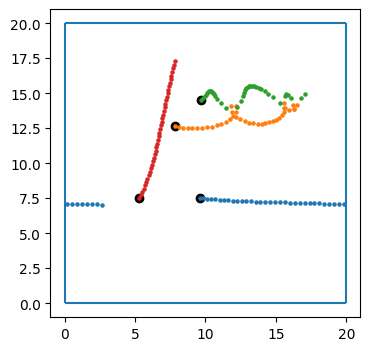

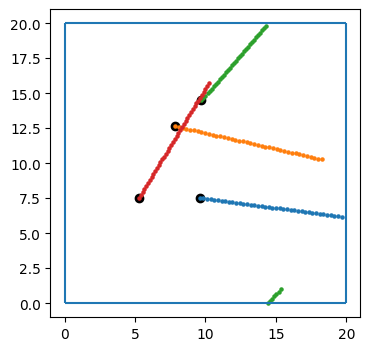

In [40]:
def linear_baseline_predict_trajectory(particles, time_steps=40, time_step_size=0.5, box_length=20.0):
    initial_positions = particles[:, :2]
    initial_velocities = particles[:, 2:4]
    initial_charges = particles[:, 4][:, np.newaxis]

    trajectory = [particles.copy()]

    for _ in range(time_steps - 1):
        new_positions = initial_positions + initial_velocities * time_step_size

        new_positions = new_positions % box_length # Apply periodic boundary conditions

        new_particles = np.concatenate([new_positions, initial_velocities, initial_charges], axis=1)
        trajectory.append(new_particles)
        initial_positions = new_positions
    
    return np.array(trajectory)

# Test the function
trajectory, energy = load_trajectory('data/task1_2/train/trajectory_0.npz', 'task_2')
particles = trajectory[0]
predicted_trajectory = linear_baseline_predict_trajectory(particles)
plot_trajectory(trajectory)
plot_trajectory(predicted_trajectory)


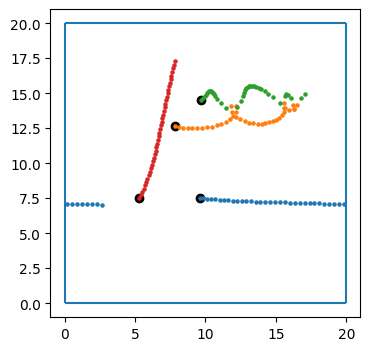

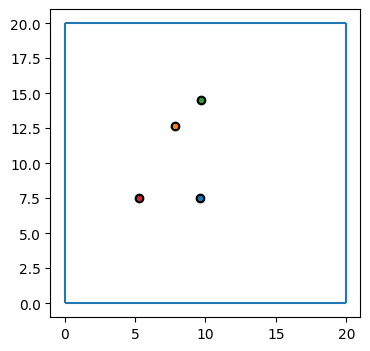

In [41]:
def constant_baseline_predict_trajectory(particles, time_steps=40, box_length=20.0):

    trajectory = [particles.copy()]

    for _ in range(time_steps - 1):
        new_particles = particles.copy()
        trajectory.append(new_particles)
    
    return np.array(trajectory)

# Test the function
trajectory, energy = load_trajectory('data/task1_2/train/trajectory_0.npz', 'task_2')
particles = trajectory[0]
predicted_trajectory = constant_baseline_predict_trajectory(particles)

plot_trajectory(trajectory)
plot_trajectory(predicted_trajectory)

In [42]:
import torch
import numpy as np

def predict_trajectory(model, particles, energy, time_steps=40, time_step_size=0.5, box_length=20.0, cutoff_value=10.0, energy_predictor=None):
    """
    Predicts the trajectory of particles using the given model.

    Args:
        model (nn.Module): The graph neural network model.
        particles (np.ndarray): A numpy array with shape (num_particles, [pos_x, pos_y, vel_x, vel_y, charge]).
        time_steps (int): The number of time steps to predict.
        time_step_size (float): The size of each time step.
        box_length (float): The length of the simulation box (assumed to be a square).
        cutoff_value (float): The cutoff distance for interactions.

    Returns:
        np.ndarray: An array with shape (time_steps, num_particles, [pos_x, pos_y, vel_x, vel_y, charge])
                    representing the states of the particles at each time step.
    """
    trajectory = [particles.copy()]  # Initial state of particles
    energy_list = [energy]  # Initial energy of the system

    def update_positions_and_velocities(current_particles, predicted_norm, predicted_sin, predicted_cos, time_step_size, box_length):
        """
        Update the positions and velocities of particles based on predicted velocities.

        Args:
            current_particles (np.ndarray): Array with shape (num_particles, [pos_x, pos_y, vel_x, vel_y, charge]).
            predicted_norm (np.ndarray): Array with shape (num_particles,) containing predicted norms of velocities.
            predicted_sin (np.ndarray): Array with shape (num_particles,) containing predicted sine components of velocities.
            predicted_cos (np.ndarray): Array with shape (num_particles,) containing predicted cosine components of velocities.
            time_step_size (float): Size of each time step.
            box_length (float): Length of the simulation box.

        Returns:
            np.ndarray: Updated array with shape (num_particles, [pos_x, pos_y, vel_x, vel_y, charge]).
        """
        pos_x, pos_y, vel_x, vel_y, charge = np.transpose(current_particles)

        # Update positions
        pos_x = (pos_x + vel_x * time_step_size) % box_length
        pos_y = (pos_y + vel_y * time_step_size) % box_length

        # Update velocities
        vel_norm = predicted_norm
        vel_x = vel_norm * predicted_cos
        vel_y = vel_norm * predicted_sin

        updated_particles = np.stack((pos_x, pos_y, vel_x, vel_y, charge), axis=-1)

        return updated_particles
    
    for _ in range(time_steps - 1):
        current_particles = trajectory[-1]
        
        current_energy = energy_list[-1]
        
        graph = create_graph_from_particles_task_2(current_particles, None, current_energy, box_length, cutoff_value)


        node_features = graph.x.clone().detach().to(device)
        edge_index = graph.edge_index.clone().detach().to(device)
        edge_attr = graph.edge_attr.clone().detach().to(device)

        # Predict the next velocities of the particles (norm, sin, cos)
        with torch.no_grad():
            predicted_norm, predicted_sin, predicted_cos = model(node_features, edge_index, edge_attr).unbind(dim=-1)
           

        # Update particle positions and velocities
        updated_particles = update_positions_and_velocities(
            torch.tensor(current_particles, dtype=float), predicted_norm, predicted_sin, predicted_cos, time_step_size, box_length
        )
        
        trajectory.append(updated_particles)

        if energy_predictor is not None:
        # Predict energy
            graph_energy = create_graph_from_particles_task_1(updated_particles, 0.0, box_length, cutoff_value)
            batched_graph = Batch.from_data_list([graph_energy]).to(device)
            predicted_energy = energy_predictor(batched_graph.x, batched_graph.edge_index, batched_graph.edge_attr, batched_graph.batch)
            energy_list.append(predicted_energy.squeeze(0).detach().numpy())
        else:
            print("Energy predictor not available")

    trajectory_np = np.stack(trajectory)
    energy_np = np.array(energy_list)

    return trajectory_np, energy_np # Return both the trajectory and the energy

[970 959 942 988 979]
Test trajectory 970


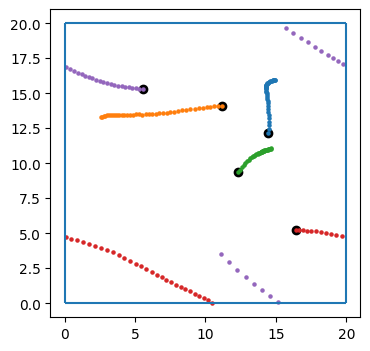

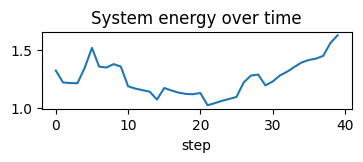

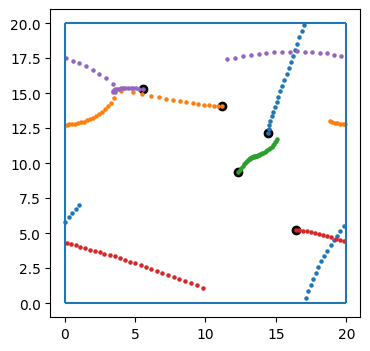

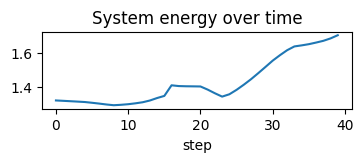

Test trajectory 959


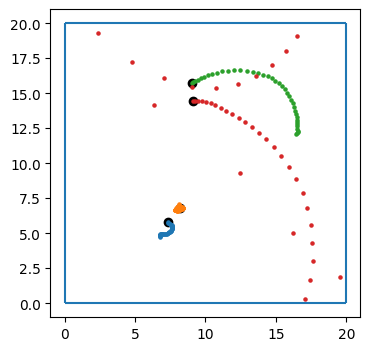

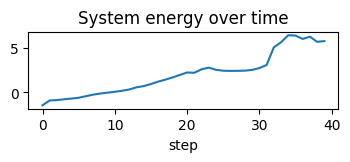

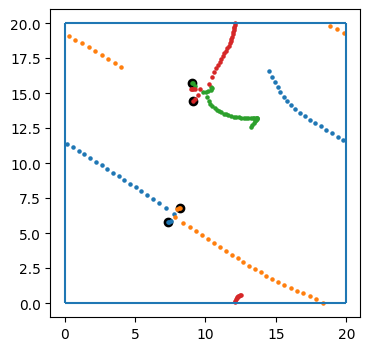

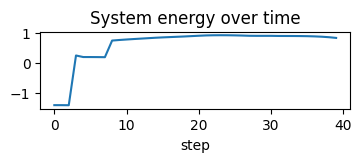

Test trajectory 942


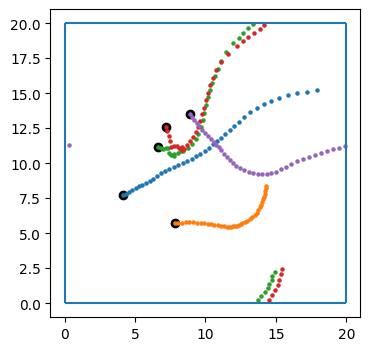

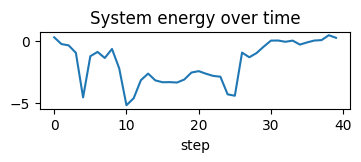

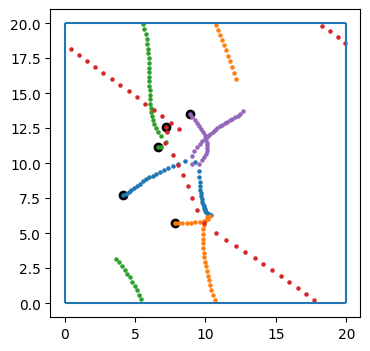

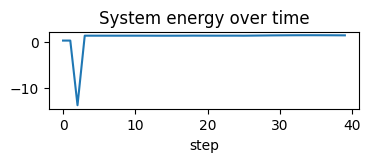

Test trajectory 988


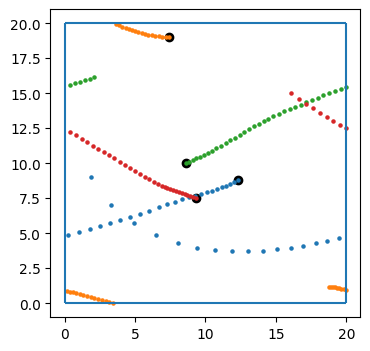

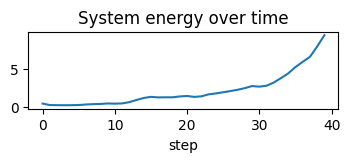

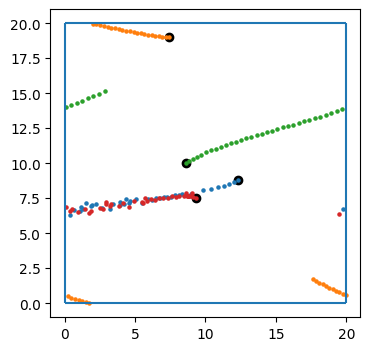

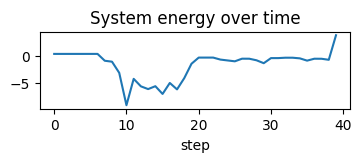

Test trajectory 979


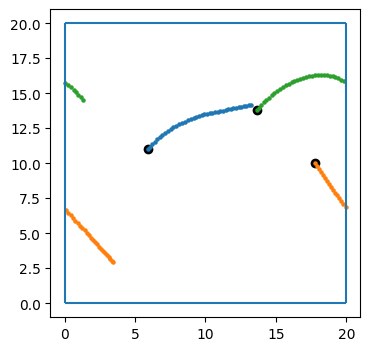

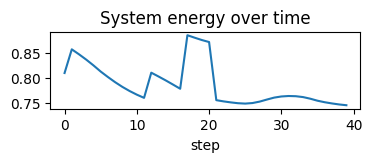

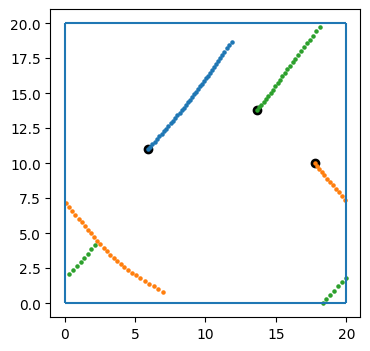

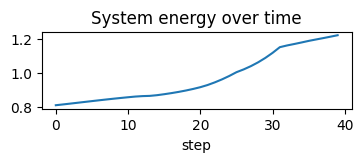

In [43]:
# Plot 5 random predictions from the test set
random_indices = np.random.randint(900, 1000, size=5)
print(random_indices)

for random_index in random_indices:
    test_trajectory, test_energy = load_trajectory(f'data/task1_2/test/trajectory_{random_index}.npz', task)
    test_particles = test_trajectory[0]
    energy = test_energy[0]
    print(f"Test trajectory {random_index}")
    predicted_trajectory, predicted_energy = predict_trajectory(model_task_2, test_particles, energy, energy_predictor=model_task_1)
    plot_trajectory(predicted_trajectory, predicted_energy)
    plot_trajectory(test_trajectory, test_energy)

### MSE

Compute the MSE of the prediction of each data point

In [44]:
def compute_loss_time_step(model, data, criterion):
    """
    This function computes the loss of the given model on the given data for each time step using the given loss function.

    Parameters:
    model (torch.nn.Module): The model to use for prediction.
    data (torch_geometric.data.Data): The data object containing the input features and target values.
    criterion (torch.nn.Module): The loss function to use for testing.

    The function first sets the model to evaluation mode. Then, it iterates over the time steps in the data. 
    For each time step, it computes the predicted values using the model, computes the loss using the criterion, 
    and keeps track of the total loss over all time steps. Finally, it returns the average loss over all time steps.
    """
    model.eval()

    with torch.no_grad():
        node_features = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        target = data.y
        output = model(node_features, edge_index, edge_attr)
        loss = criterion(output, target)    

    return loss.item()

In [45]:
# Create a test dataset
test_paths_task_2 = glob.glob('data/task1_2/test/*.npz')
test_dataset = ParticleDynamicsDataset(test_paths_task_2, max_len, box_length, cutoff)
print(f'Test dataset: {len(test_dataset)} samples')

Loading data: 100%|██████████| 100/100 [00:00<00:00, 182.81it/s]

Test dataset: 3900 samples


In [46]:
def compute_mean_loss(model, test_dataset, criterion):
    """
    This function computes the mean loss of the given model on the given test dataset using the given loss function.

    Parameters:
    model (torch.nn.Module): The model to use for prediction.
    test_dataset (ParticleDynamicsDataset): The test dataset.
    criterion (torch.nn.Module): The loss function to use for testing.

    The function iterates over the test dataset. For each data point, it computes the loss using the given model and loss function. 
    The function keeps track of the total loss over all data points. Finally, it returns the average loss over all data points.
    """
    total_loss = 0
    for data in test_dataset:
        total_loss += compute_loss_time_step(model, data, criterion)
    return total_loss / len(test_dataset)

criterion = torch.nn.MSELoss()
mean_loss = compute_mean_loss(model_task_2, test_dataset, criterion)
print(f'Mean loss on test set: {mean_loss}')

Mean loss on test set: 0.04195643558764296


Compute the MSE of the whole trajectory

In [47]:

def compute_loss_trajectory(trajectory, predicted_trajectory, criterion):
    """
    This function computes the loss of the given model on the given trajectory using the given loss function.
    It only considers the positions of the particles.

    Parameters:
    model (torch.nn.Module): The model to use for prediction.
    trajectory (np.ndarray): The trajectory of the system.
    criterion (torch.nn.Module): The loss function to use for testing.

    The function first creates a graph representation of the trajectory. 
    Then, it computes the loss of the model on the trajectory using the given loss function. 
    Finally, it returns the loss.
    """

    # Consider only positions
    predicted_positions = predicted_trajectory[:, :, :2]
    true_positions = trajectory[:, :, :2]

    loss = criterion(torch.tensor(predicted_positions, dtype=torch.float32), torch.tensor(true_positions, dtype=torch.float32))

    return loss.item()

In [48]:

def compute_mean_losses_trajectory(model, test_paths, criterion, energy_predictor):
    """
    Compute the mean loss across multiple trajectories.

    Args:
        model (torch.nn.Module): The model used to predict trajectories.
        test_paths (list): List of paths to test trajectories.
        criterion (callable): The loss function to compute the difference between predicted and actual trajectories.

    Returns:
        float: The mean loss over all test trajectories.
    """
    total_loss = 0
    total_loss_linear = 0
    total_loss_constant = 0
    num_paths = 0

    for path in test_paths:
        trajectory, energy = load_trajectory(path, 'task_2')

        particles = trajectory[0]
        energy_test = energy[0]
        predicted_trajectory, _ = predict_trajectory(model, particles, energy_test, energy_predictor=energy_predictor)
        predicted_trajectory_linear = linear_baseline_predict_trajectory(particles)
        predicted_trajectory_constant = constant_baseline_predict_trajectory(particles)

        loss = compute_loss_trajectory(trajectory, predicted_trajectory, criterion)
        
        if np.isnan(loss): # There is one trajectory with NaN loss, caused by augmented data
            loss = 0
            num_paths -= 1

        loss_linear = compute_loss_trajectory(trajectory, predicted_trajectory_linear, criterion)
        loss_constant = compute_loss_trajectory(trajectory, predicted_trajectory_constant, criterion)

        # print(f'Loss for trajectory {path}: {loss}')
        total_loss += loss
        total_loss_linear += loss_linear
        total_loss_constant += loss_constant
        num_paths += 1

    return total_loss / num_paths, total_loss_linear / num_paths, total_loss_constant / num_paths


mean_loss_trajectory, mean_loss_trajectory_linear, mean_loss_trajectory_constant = compute_mean_losses_trajectory(model_task_2, train_paths_task_2, criterion, model_task_1)
print(f'Mean loss on train set trajectories: {mean_loss_trajectory}')
print(f'Mean loss on train set trajectories (linear baseline): {mean_loss_trajectory_linear}')
print(f'Mean loss on train set trajectories (constant baseline): {mean_loss_trajectory_constant}')

mean_loss_trajectory, mean_loss_trajectory_linear, mean_loss_trajectory_constant = compute_mean_losses_trajectory(model_task_2, val_paths_task_2, criterion, model_task_1)
print(f'Mean loss on validation set trajectories: {mean_loss_trajectory}')
print(f'Mean loss on validation set trajectories (linear baseline): {mean_loss_trajectory_linear}')
print(f'Mean loss on validation set trajectories (constant baseline): {mean_loss_trajectory_constant}')

mean_loss_trajectory, mean_loss_trajectory_linear, mean_loss_trajectory_constant = compute_mean_losses_trajectory(model_task_2, test_paths_task_2, criterion, model_task_1)
print(f'Mean loss on test set trajectories: {mean_loss_trajectory}')
print(f'Mean loss on test set trajectories (linear baseline): {mean_loss_trajectory_linear}')
print(f'Mean loss on test set trajectories (constant baseline): {mean_loss_trajectory_constant}')

Mean loss on train set trajectories: 30.358762481425067
Mean loss on train set trajectories (linear baseline): 25.61860682611924
Mean loss on train set trajectories (constant baseline): 26.09957775671715
Mean loss on validation set trajectories: 30.96370620941848
Mean loss on validation set trajectories (linear baseline): 26.81297546558166
Mean loss on validation set trajectories (constant baseline): 27.42059229732899
Mean loss on test set trajectories: 32.302267069768426
Mean loss on test set trajectories (linear baseline): 26.064698881573147
Mean loss on test set trajectories (constant baseline): 27.041343905709006


### Rotation Equivariance

In [49]:
import numpy as np

def rotate_particles(particles, angle_degrees, box_size=20):
    """
    Rotates the particles by the given angle in degrees.

    Args:
        particles (np.ndarray): A 2D numpy array representing the particles. Each row represents a particle, with columns for the particle's x and y coordinates, x and y velocities, and charge.
        angle_degrees (float): The angle by which to rotate the particles, in degrees. Positive values represent counter-clockwise rotation, and negative values represent clockwise rotation.

    Returns:
        np.ndarray: A 2D numpy array of the same shape as `particles`, representing the particles after rotation. The x and y coordinates and velocities of the particles have been rotated by `angle_degrees`, but the charges of the particles are unchanged.
    """
    # Convert angle from degrees to radians
    angle_radians = np.radians(angle_degrees)
    
    # Rotation matrix for 2D rotation
    rotation_matrix = np.array([
        [np.cos(angle_radians), -np.sin(angle_radians)],
        [np.sin(angle_radians), np.cos(angle_radians)]
    ])
    
    # Separate the components of the particles
    pos_x = particles[:, 0]
    pos_y = particles[:, 1]
    vel_x = particles[:, 2]
    vel_y = particles[:, 3]
    charge = particles[:, 4]
    
    # Apply rotation to positions
    positions = np.vstack((pos_x, pos_y))
    rotated_positions = rotation_matrix @ positions
    
    # Minimum image convention to ensure positions stay within the range [0, box_size]
    rotated_pos_x = (rotated_positions[0, :] + box_size) % box_size
    rotated_pos_y = (rotated_positions[1, :] + box_size) % box_size
    
    # Apply rotation to velocities
    velocities = np.vstack((vel_x, vel_y))
    rotated_velocities = rotation_matrix @ velocities
    rotated_vel_x = rotated_velocities[0, :]
    rotated_vel_y = rotated_velocities[1, :]
    
    # Combine the rotated components back into the particles array
    rotated_particles = np.vstack((rotated_pos_x, rotated_pos_y, rotated_vel_x, rotated_vel_y, charge)).T
    
    return rotated_particles

970
Test trajectory 970


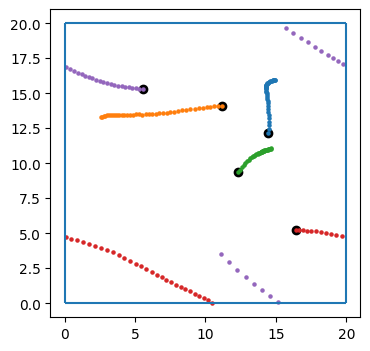

Rotated by 30 degrees


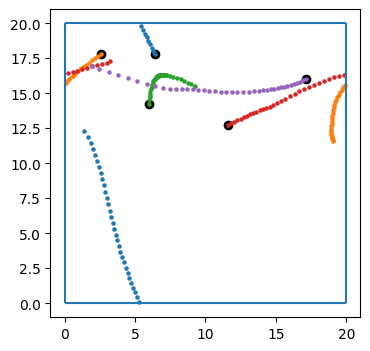

Rotated by 90 degrees


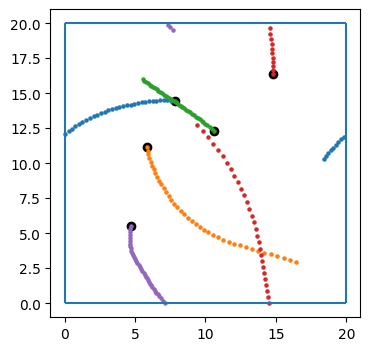

Rotated by 150 degrees


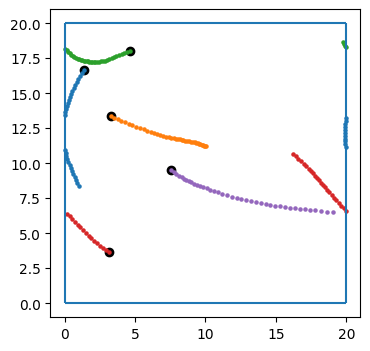

In [50]:
# Plot a random prediction from the test set after rotating the particles by 30, 90, and 150 degrees
random_index = np.random.randint(900, 1000)
angles = [30, 90, 150]
print(random_index)

test_trajectory, energy = load_trajectory(f'data/task1_2/test/trajectory_{random_index}.npz', task)

def plot_predicted_rotations(model, trajectory, energy, angles, energy_predictor):
    """
    Plot the predicted trajectories of particles before and after applying rotations.

    Args:
        model (torch.nn.Module): The model used to predict trajectories.
        test_trajectory (numpy.ndarray): The initial trajectory of particles with shape (timesteps, num_particles, 5).
        angles (list of float): The list of angles in degrees by which to rotate the particles.
    """
    test_particles = trajectory[0]
    test_energy = energy[0]

    print(f"Test trajectory {random_index}")
    predicted_trajectory, _ = predict_trajectory(model, test_particles, test_energy, energy_predictor=energy_predictor)
    plot_trajectory(predicted_trajectory)

    for angle in angles:
        rotated_particles = rotate_particles(test_particles, angle)
        print(f"Rotated by {angle} degrees")
        rotated_predicted_trajectory, _ = predict_trajectory(model, rotated_particles, test_energy, energy_predictor=energy_predictor)
        plot_trajectory(rotated_predicted_trajectory)

plot_predicted_rotations(model_task_2, test_trajectory, energy, angles, model_task_1)

In [51]:
def compute_rotation_loss(model, particles, energy, criterion, angle_degrees, energy_predictor):
    """
    Compute the rotation loss for a given model and set of particles.
    
    Parameters:
    model: The model used to predict the trajectory.
    particles: The initial state of the particles.
    criterion: The loss function used to compute the loss.
    angle_degrees: The angle by which to rotate the particles.

    Returns:
    The computed loss as a float.
    """
    
    # Predict the trajectory for the original particles and rotate it
    predicted_trajectory, _ = predict_trajectory(model, particles, energy, energy_predictor=energy_predictor)
    predicted_trajectory_rotated = [rotate_particles(particles, angle_degrees) for particles in predicted_trajectory]
    predicted_trajectory_rotated = np.stack(predicted_trajectory_rotated)

    # Rotate the particles and predict the trajectory
    rotated_particles = rotate_particles(particles, angle_degrees)
    rotated_predicted_trajectory, _ = predict_trajectory(model, rotated_particles, energy, energy_predictor=energy_predictor)
    
    # Consider only positions
    predicted_positions_1 = predicted_trajectory_rotated[:, :, :2]
    predicted_positions_2 = rotated_predicted_trajectory[:, :, :2]

    loss = criterion(torch.tensor(predicted_positions_1, dtype=torch.float32), torch.tensor(predicted_positions_2, dtype=torch.float32))

    loss = loss.item()
    if np.isnan(loss):
        return 0
    return loss

def compute_mean_rotation_loss(model, test_paths, criterion, angle_degrees_list, energy_predictor, task):
    """
    Compute the mean rotation loss for a given model and set of test paths.
    
    Parameters:
    model: The model used to predict the trajectory.
    test_paths: The paths to the test data.
    criterion: The loss function used to compute the loss.
    angle_degrees_list: A list of angles by which to rotate the particles.

    Returns:
    The mean computed loss as a float.
    """
    total_loss = 0
    for path in tqdm(test_paths, desc='Computing rotation loss'):
        trajectory, energy = load_trajectory(path, task)
        particles = trajectory[0]
        energy = energy[0]
        for angle_degrees in angle_degrees_list:
            loss = compute_rotation_loss(model, particles, energy, criterion, angle_degrees, energy_predictor)
            
            total_loss += loss
    return total_loss / (len(test_paths) * len(angle_degrees_list))

angle_degrees_list = [30, 90, 150]
mean_rotation_loss = compute_mean_rotation_loss(model_task_2, test_paths_task_2, criterion, angle_degrees_list, model_task_1, task)
print(f'Mean rotation loss on test set: {mean_rotation_loss}')

Computing rotation loss:  39%|███▉      | 39/100 [00:22<00:35,  1.70it/s]/var/folders/43/zvsqfyrj1hlfqtzzdgxqzt080000gn/T/ipykernel_10614/1964235916.py:40: RuntimeWarning: invalid value encountered in matmul
  rotated_velocities = rotation_matrix @ velocities
Computing rotation loss: 100%|██████████| 100/100 [00:56<00:00,  1.77it/s]

Mean rotation loss on test set: 30.359922563234964


### Translation Equivariance

In [52]:
import numpy as np

def shift_particles(particles, shift_vector):
    """
    Shifts the positions of particles by a given vector, wrapping around within a range of [0, 20].
    
    Parameters:
    particles: A numpy array of shape (num_particles, 5), where each row represents a particle and the columns represent the x position, y position, x velocity, y velocity, and charge, respectively.
    shift_vector: A numpy array of shape (2,) representing the x and y components of the shift vector.

    Returns:
    A numpy array of shape (num_particles, 5) representing the shifted particles.
    """
    # Separate the components of the particles
    pos_x = particles[:, 0]
    pos_y = particles[:, 1]
    vel_x = particles[:, 2]
    vel_y = particles[:, 3]
    charge = particles[:, 4]
    
    # Apply the shift vector to the positions
    shifted_pos_x = pos_x + shift_vector[0]
    shifted_pos_y = pos_y + shift_vector[1]
    
    # Ensure the positions stay within the range [0, 20] by wrapping around
    shifted_pos_x = np.mod(shifted_pos_x, 20)
    shifted_pos_y = np.mod(shifted_pos_y, 20)
    
    # Combine the shifted positions with the unchanged velocities and charges
    shifted_particles = np.vstack((shifted_pos_x, shifted_pos_y, vel_x, vel_y, charge)).T
    
    return shifted_particles

970
Shift vector: [11.86218898  9.6322546 ]


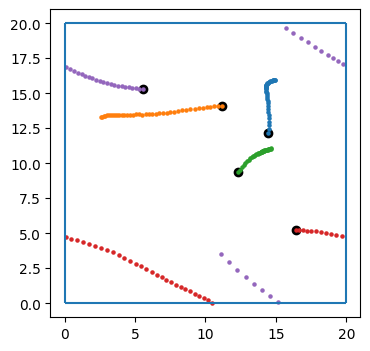

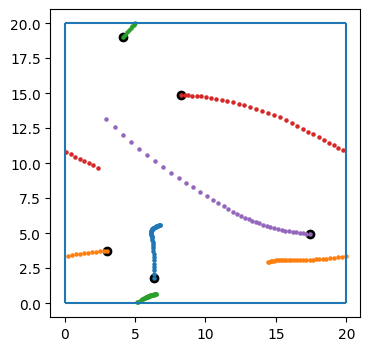

In [53]:
# Plot a random prediction from the test set after rotating the particles by 30, 90, and 150 degrees
random_index = np.random.randint(900, 1000)
print(random_index)

# Generate a random shift vector for x and y within the range [0, 20]
shift_vector = np.random.uniform(0, 20, size=2)
print(f"Shift vector: {shift_vector}")

test_trajectory, test_energy = load_trajectory(f'data/task1_2/test/trajectory_{random_index}.npz', task)

def plot_predicted_shifts(model, test_trajectory, test_energy, shift_vector, energy_predictor):
    """
    Plot the predicted trajectories of particles before and after applying a shift.

    Args:
        model (torch.nn.Module): The model used to predict trajectories.
        test_trajectory (numpy.ndarray): The initial trajectory of particles with shape (timesteps, num_particles, 5).
        shift_vector (numpy.ndarray): The vector by which to shift the particles.
    """
    test_particles = test_trajectory[0]
    test_energy = test_energy[0]
    predicted_trajectory, _ = predict_trajectory(model, test_particles, test_energy, energy_predictor=energy_predictor)
    plot_trajectory(predicted_trajectory)

    shifted_particles = shift_particles(test_particles, shift_vector)
    shifted_predicted_trajectory, _ = predict_trajectory(model, shifted_particles, test_energy, energy_predictor=energy_predictor)
    plot_trajectory(shifted_predicted_trajectory)

plot_predicted_shifts(model_task_2, test_trajectory, test_energy, shift_vector, model_task_1)

In [54]:
def compute_shift_loss(model, particles, energy, criterion, shift_vector, energy_predictor):
    """
    Compute the shift loss between the predicted trajectories of the original
    and shifted particles.

    Args:
        model (torch.nn.Module): The model used to predict trajectories.
        particles (numpy.ndarray): The initial array of particles with shape (num_particles, 5).
        criterion (callable): The loss function to compute the difference between trajectories.
        shift_vector (numpy.ndarray): The vector by which to shift the particles.

    Returns:
        float: The computed shift loss.
    """
    # Predict the trajectory and shift it
    predicted_trajectory, _ = predict_trajectory(model, particles, energy, energy_predictor=energy_predictor)
    shifted_trajectory = [shift_particles(particles, shift_vector) for particles in predicted_trajectory]
    shifted_trajectory = np.stack(shifted_trajectory)

    # Shift the particles and predict the trajectory
    shifted_particles = shift_particles(particles, shift_vector)
    shifted_predicted_trajectory, _ = predict_trajectory(model, shifted_particles, energy, energy_predictor=energy_predictor)
    
    # Consider only positions
    predicted_positions_1 = shifted_trajectory[:, :, :2]
    predicted_positions_2 = shifted_predicted_trajectory[:, :, :2]

    loss = criterion(torch.tensor(predicted_positions_1, dtype=torch.float32), torch.tensor(predicted_positions_2, dtype=torch.float32))
    return loss.item()

def compute_mean_shift_loss(model, test_paths, criterion, shift_vector, energy_predictor, task):
    """
    Compute the mean shift loss across multiple test paths.

    Args:
        model (torch.nn.Module): The model used to predict trajectories.
        test_paths (list): The list of paths to test trajectories.
        criterion (callable): The loss function to compute the difference between trajectories.
        shift_vector (numpy.ndarray): The vector by which to shift the particles.

    Returns:
        float: The mean shift loss over all test paths.
    """
    total_loss = 0
    num_paths = 0
    for path in tqdm(test_paths, desc='Computing shift loss'):
        trajectory, energy = load_trajectory(path, task)
        particles = trajectory[0]
        energy = energy[0]
        loss = compute_shift_loss(model, particles, energy, criterion, shift_vector, energy_predictor)
        if np.isnan(loss):
            loss = 0
            num_paths -= 1
        total_loss += loss
        num_paths += 1
    return total_loss / len(test_paths)

mean_shift_loss = compute_mean_shift_loss(model_task_2, test_paths_task_2, criterion, shift_vector, model_task_1, task)
print(f'Mean shift loss on test set: {mean_shift_loss}')

Computing shift loss: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]

Mean shift loss on test set: 0.0


# Task 3

In task 3, you also need to model the influences of the crystal. An example of loading a trajectory can be found below. The trajectory and energy data has the same shape as before, however, data regarding the crystal has been added. Since atoms belonging to the crystal do not move, this data does not have a time dimension when loaded. The shapes of the arrays are as follows:

```trajectory```: ```(time, n_bodies, [x, y, v_x, v_y, q])```

```energy```: ```(time, 1)```

```framework```:```(n_framework_atom, [x, y, q])```



In [55]:
trajectory, framework, energy = load_trajectory('data/task3/train/trajectory_0.npz', 'task_3')
print(f'Trajectory shape: {trajectory.shape}, Framework shape: {framework.shape}, Energy shape: {energy.shape}')

Trajectory shape: (40, 4, 5), Framework shape: (20, 3), Energy shape: (40, 1)


The following code provides an example of how to visualize a trajectory with a crystal. Feel free to modify this code, or write your own function. When evaluating your model in this task, keep in mind that you are only allowed to use the data at t=0 (the black dots in the visualization).

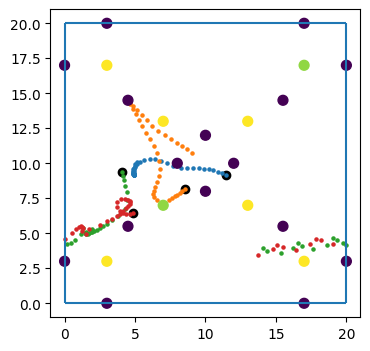

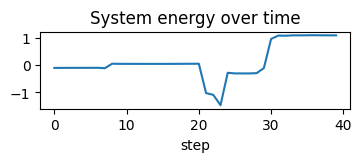

In [56]:
def plot_trajectory_crystal(trajectory, framework, energy):
    x = trajectory[...,0]
    y = trajectory[...,1]

    x_fw = framework[...,0]
    y_fw = framework[...,1]
    q_fw = framework[...,2]

    plt.figure(figsize=(4,4))
    plt.vlines([0,20],0,20)
    plt.hlines([0,20],0,20)

    plt.scatter(x[0], y[0], c='black')

    for i in range(x.shape[1]):
        plt.scatter(x[:,i], y[:,i], s=5)

    plt.scatter(x_fw, y_fw, c=q_fw, cmap='viridis', s=50)
    # to also visualize the framework points along the boundaries
    plt.scatter(x_fw+20, y_fw, c=q_fw, cmap='viridis', s=50)
    plt.scatter(x_fw, y_fw+20, c=q_fw, cmap='viridis', s=50)
    plt.scatter(x_fw+20, y_fw+20, c=q_fw, cmap='viridis', s=50)

    plt.xlim(-1,21)
    plt.ylim(-1,21)

    plt.show()
    plt.figure(figsize=(4,1))
    plt.plot(energy)
    plt.xlabel('step')
    plt.title('System energy over time')
    plt.show();

plot_trajectory_crystal(trajectory, framework, energy)

Implement task 3 below. Feel free to add extra code cells for different components of your implementation.

In [57]:
def create_graph_from_particles_task_3(particles, crystal_particles, next_particles=None, energy=0.0, box_length=20.0, cutoff_value=10.0):
    """
    This function creates a graph representation of a system of particles for use in graph neural networks. 
    Each particle is represented as a node in the graph, and edges are created between particles that are within a certain cutoff distance of each other.

    Parameters:
    particles (numpy.ndarray): A 2D array representing the particles in the system. 
                               Each row represents a particle, with the first two columns representing the x and y coordinates of the particle, 
                               and the remaining columns representing additional features of the particle.
    crystal_particles (numpy.ndarray): A 2D array representing the crystal particles in the system.
                                       Each row represents a crystal particle, with the first two columns representing the x and y coordinates of the particle,
                                       and the remaining columns representing additional features of the particle.
    next_particles (numpy.ndarray, optional): A 2D array representing the next state of the particles for training. 
                                              Each row represents a particle, with the first two columns representing the x and y coordinates of the particle,
                                              and the remaining columns representing additional features of the particle.
    energy (float, optional): The energy of the system. Defaults to 0.0.
    box_length (float, optional): The length of the box in which the particles are contained. 
                                  This is used to calculate the minimum image distance between particles. Defaults to 20.0.
    cutoff_value (float, optional): The maximum distance at which two particles are considered to be connected by an edge. Defaults to 10.0.

    Returns:
    torch_geometric.data.Data: A Data object representing the graph. 
                               The node features, edge indices, edge attributes, and energy are stored as attributes of this object.
    """

    # Particles features
    num_particles = particles.shape[0]
    num_crystal_particles = crystal_particles.shape[0]

    velocity_x = particles[:, 2]
    velocity_y = particles[:, 3]
    charge = particles[:, 4][:, np.newaxis]

    pol_coords = convert_to_polar_coordinates(velocity_x, velocity_y)
    norm = pol_coords[:, 0][:, np.newaxis]
    angle = pol_coords[:, 1][:, np.newaxis]

    # Use sine and cosine of the angle
    sin_angle = np.sin(angle)
    cos_angle = np.cos(angle)

    # Create energy vector to be used as node feature
    energy_list = np.array([energy] * num_particles)


    # Combine node features for movable particles
    x = np.concatenate((norm, sin_angle, cos_angle, charge, energy_list), axis=-1)

    crystal_norm = np.array([0.0] * num_crystal_particles)[:,np.newaxis]  # Crystal particles have zero norm as a placeholder
    crystal_sin_angle = np.array([0.0] * num_crystal_particles)[:,np.newaxis]  # Crystal particles have zero angle as a placeholder
    crystal_cos_angle = np.array([0.0] * num_crystal_particles)[:,np.newaxis]  # Crystal particles have zero angle as a placeholder
    crystal_charge = crystal_particles[:, 2][:,np.newaxis]  # Crystal particles have charge as the third feature
    crystal_energy = np.array([energy] * num_crystal_particles)

    # Combine node features for crystal particles
    crystal_x = np.concatenate((crystal_norm, crystal_sin_angle, crystal_cos_angle, crystal_charge, crystal_energy), axis=-1)

    # Combine movable and crystal node features
    x = np.concatenate((x, crystal_x), axis=0)

    edge_index = []
    edge_attr = []
    for i in range(num_particles + num_crystal_particles):
        for j in range(num_particles + num_crystal_particles):
            if i != j:  # Avoid self-loops

                pos1 = particles[i, :2] if i < num_particles else crystal_particles[i - num_particles, :2]
                pos2 = particles[j, :2] if j < num_particles else crystal_particles[j - num_particles, :2]
                distance = minimum_image_distance(pos1, pos2, box_length)

                edge_index.append([i, j])
                if distance < cutoff_value:
                    edge_attr.append(distance)
                else:
                    edge_attr.append(-1.0)  # Use -1.0 as padding value

    x = torch.tensor(x, dtype=torch.float)
    edge_index = torch.tensor(edge_index).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    # Create masks
    movable_mask = torch.zeros(num_particles + num_crystal_particles, dtype=torch.bool)
    movable_mask[:num_particles] = True

    if next_particles is not None:  # For training, set target y in Data object
        next_velocity_x = next_particles[:, 2]
        next_velocity_y = next_particles[:, 3]

        next_polar_coords = convert_to_polar_coordinates(next_velocity_x, next_velocity_y)
        next_norm = next_polar_coords[:, 0][:, np.newaxis]
        next_angle = next_polar_coords[:, 1][:, np.newaxis]

        next_sin_angle = np.sin(next_angle)
        next_cos_angle = np.cos(next_angle)

        target = np.concatenate((next_norm, next_sin_angle, next_cos_angle), axis=-1)
        target = torch.tensor(target, dtype=torch.float)  # Use next velocity as target

        # Create Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=(target, movable_mask))
    else:  # For testing, do not set target y in Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=(None, movable_mask))

    # Validate data object
    data.validate(raise_on_error=True)

    return data

trajectory, framework, energy = load_trajectory('data/task3/train/trajectory_0.npz', 'task_3')
print(f'Trajectory shape: {trajectory.shape}, Framework shape: {framework.shape}, Energy shape: {energy.shape}')
particles = trajectory[0]

next_particles = trajectory[1]
energy = energy[0]
print(f'Particles shape: {particles.shape}, Energy: {energy}')
data = create_graph_from_particles_task_3(particles, framework, next_particles, energy, box_length=20.0, cutoff_value=10.0)
print(data)

Trajectory shape: (40, 4, 5), Framework shape: (20, 3), Energy shape: (40, 1)
Particles shape: (4, 5), Energy: [-0.10511058]
Data(x=[24, 5], edge_index=[2, 552], edge_attr=[552], y=[2])


In [58]:

def create_particle_data_list_task_3(trajectory, energies, framework, box_length=20.0, cutoff_value=10.0):
    """
    This function creates a list of graph representations of a system of particles for each time step in a trajectory. 
    Each particle is represented as a node in the graph, and edges are created between particles that are within a certain cutoff distance of each other.

    Parameters:
    trajectory (numpy.ndarray): A 3D array representing the trajectory of the system. 
                                The first dimension represents time, the second dimension represents particles, 
                                and the third dimension represents the x and y coordinates of the particles.
    energies (numpy.ndarray): A 1D array representing the energy of the system at each time step.
    box_length (float, optional): The length of the box in which the particles are contained. 
                                  This is used to calculate the minimum image distance between particles. Defaults to 20.0.
    cutoff_value (float, optional): The maximum distance at which two particles are considered to be connected by an edge. Defaults to 10.0.

    Returns:
    list: A list of PyTorch Geometric Data objects, each representing the graph of the system at a different time step.

    The function iterates over each time step in the trajectory, creating a graph for each one and appending it to the list. 
    The graphs are created using the create_graph_from_particles function.
    """
    particle_data_list = []
    for i in range(trajectory.shape[0] - 1):
        particles = trajectory[i]
        next_particles = trajectory[i+1]
        energy = energies[i]
        particle_data_list.append(create_graph_from_particles_task_3(particles, framework, next_particles, energy, box_length, cutoff_value))

    return particle_data_list

trajectory, framework, energy = load_trajectory('data/task3/train/trajectory_0.npz', 'task_3')

print(f'Trajectory shape: {trajectory.shape}, Framework shape: {framework.shape}, Energy shape: {energy.shape}')

particle_data_list = create_particle_data_list_task_3(trajectory, energy, framework)

particles = trajectory[0]
energy = energy[0]
next_particles = trajectory[1]
print(f'Particles ({particles.shape}):\n {particles}')
print(f'Energy: {energy}')
print(f'Next Particles ({next_particles.shape}):\n {next_particles}')

particles_graph = particle_data_list[0]
print(f'Particles graph x:\n {particles_graph.x}')
print(f'Particles graph y (next):\n {particles_graph.y}')

Trajectory shape: (40, 4, 5), Framework shape: (20, 3), Energy shape: (40, 1)
Particles ((4, 5)):
 [[11.42151381  9.1820005  -0.51819542  0.20520624  1.        ]
 [ 8.52106404  8.17804035 -0.36579602 -0.29818326 -1.        ]
 [ 4.08233323  9.39568632  0.11607758 -0.54596532  1.        ]
 [ 4.83846142  6.43495486 -0.43699743 -0.17080254 -1.        ]]
Energy: [-0.10511058]
Next Particles ((4, 5)):
 [[11.15200866  9.28779903 -0.55882539  0.21420421  1.        ]
 [ 8.34322945  8.03237978 -0.34666996 -0.28454935 -1.        ]
 [ 4.14646792  9.10699526  0.14035376 -0.61080478  1.        ]
 [ 4.6185935   6.37381374 -0.44397798 -0.06923895 -1.        ]]
Particles graph x:
 tensor([[ 0.5573,  0.3682, -0.9298,  1.0000, -0.1051],
        [ 0.4719, -0.6318, -0.7751, -1.0000, -0.1051],
        [ 0.5582, -0.9781,  0.2080,  1.0000, -0.1051],
        [ 0.4692, -0.3640, -0.9314, -1.0000, -0.1051],
        [ 0.0000,  0.0000,  0.0000,  0.2000, -0.1051],
        [ 0.0000,  0.0000,  0.0000,  0.2000, -0.1051

In [59]:
def rotate_graph_crystal(data, angle_degrees):
    """
    Rotates the graph by a given angle in degrees.

    Args:
        data (Data): A PyTorch Geometric Data object containing node features, edge index, and edge attributes.
        angle_degrees (float): The angle by which to rotate the graph, in degrees.

    Returns:
        Data: A PyTorch Geometric Data object containing the rotated node features, edge index, and edge attributes.
    """
    node_features = data.x
    edge_index = data.edge_index
    edge_attr = data.edge_attr
    target, mask = data.y

    rotated_features = node_features.clone()

    # Convert angle from degrees to radians
    angle_radians = math.radians(angle_degrees)

    # Extract norm, sin, cos, charge
    norm = node_features[:, 0]
    sin = node_features[:, 1]
    cos = node_features[:, 2]
    charge = node_features[:, 3]
    energy = node_features[:, 4]

    # Calculate the new sin and cos using the rotation matrix
    new_sin = sin * math.cos(angle_radians) - cos * math.sin(angle_radians)
    new_cos = sin * math.sin(angle_radians) + cos * math.cos(angle_radians)

    # Update the rotated features
    rotated_features[:, 0] = norm
    rotated_features[:, 1] = new_sin
    rotated_features[:, 2] = new_cos
    rotated_features[:, 3] = charge
    rotated_features[:, 4] = energy

    # Edge attributes remain the same
    rotated_edge_attr = edge_attr.clone()

    # Create and return a new Data object with the rotated features
    rotated_data = Data(x=rotated_features, edge_index=edge_index, edge_attr=rotated_edge_attr, y=(target, mask))

    return rotated_data

In [60]:
class ParticleDynamicsCrystalDataset():
    def __init__(self, file_paths, max_len=40, box_length=20.0, cutoff=10.0):
        """
        The ParticleDynamicsDataset class is used to represent a dataset of particle dynamics. 
        It is initialized with a list of file paths, each of which points to a file containing data for a single trajectory of particles. 
        The class also takes parameters for the maximum number of particles (`max_len`), 
        the length of the box in which the particles are contained (`box_length`), 
        and the cutoff distance for interactions between particles (`cutoff`).
        """
        self.file_paths = file_paths
        self.max_len = max_len
        self.box_length = box_length
        self.task = "task_3"
        self.cutoff = cutoff
        self.data_list = []
        self.augmented = False

        for file_path in tqdm(file_paths, desc="Loading data"):
            trajectory, framework, energy = load_trajectory(file_path, self.task)
            particle_data_list = create_particle_data_list_task_3(trajectory, energy, framework, self.box_length, self.cutoff)
            self.data_list += particle_data_list
    
    def __len__(self):
        """
        Returns the length of the dataset, i.e., the number of time steps in all trajectories.
        """
        return len(self.data_list)
    
    def __getitem__(self, idx):
        """
        Returns the Data object at the given index.
        """
        return self.data_list[idx]

    def augment_data(self, rotation_step=10):
        """
        Augments the dataset by rotating the graphs and targets.

        Returns:
        list: A list of PyTorch Geometric Data objects with the augmented graphs.
        """
        if self.augmented:
            print("Data already augmented")
            return
        
        self.augmented = True
        augmented_data = []

        for data in tqdm(self.data_list, desc="Augmenting data"):
            angles = [i for i in range(1, 360, rotation_step)]
            for angle in angles:
                rotated_data = rotate_graph_crystal(data, angle)
                curr_target, mask = rotated_data.y
                rotated_target = rotate_target(curr_target, angle)
                rotated_data.y = (rotated_target, mask)
                augmented_data.append(rotated_data)
        
        self.data_list += augmented_data

In [61]:
task = 'task_3'  # The task to perform

In [62]:
from sklearn.model_selection import train_test_split
import glob
import pickle
import os

# Define the paths and parameters
file_paths = glob.glob('data/task3/train/*.npz')

max_len = 40  # The maximum length of the trajectories is 40
box_length = 20.0  # The length of the simulation box
cutoff = 10.0  # The cutoff distance for the edges

train_paths_task_3, val_paths_task_3 = train_test_split(file_paths, test_size=0.2, random_state=42)

train_dataset_task_3 = ParticleDynamicsCrystalDataset(train_paths_task_3, max_len, box_length, cutoff)
val_dataset_task_3 = ParticleDynamicsCrystalDataset(val_paths_task_3, max_len, box_length, cutoff)

print(f'Train dataset: {len(train_dataset_task_3)} samples')
print(f'Validation dataset: {len(val_dataset_task_3)} samples')

Loading data: 100%|██████████| 180/180 [00:22<00:00,  8.16it/s]

Train dataset: 28080 samples
Validation dataset: 7020 samples


In [63]:
# Augment the training dataset
train_dataset_task_3.augment_data(10)

In [66]:
from torch_geometric.loader import DataLoader

batch_size = 64

# Create data loaders
train_loader_task_3 = DataLoader(train_dataset_task_3, batch_size=batch_size, shuffle=True)
val_loader_task_3 = DataLoader(val_dataset_task_3, batch_size=batch_size, shuffle=False)

for data in train_loader_task_3:
    print(data)
    break

DataBatch(x=[1550, 5], edge_index=[2, 36024], edge_attr=[36024], y=[2], batch=[1550], ptr=[65])


In [67]:
num_features = int(train_dataset_task_3[0].x.shape[1])
print(f"Num features: {num_features}")
num_targets = int(train_dataset_task_3[0].y[0].shape[1])
print(f"Num targets: {num_targets}")

Num features: 5
Num targets: 3


In [68]:
import torch.nn as nn
class MpGNN_task_3(nn.Module):
    """
    This class is a PyTorch module that represents a message passing graph neural network.

    Attributes:
    node_to_emb (Node_to_emb): A module that transforms node features into node embeddings.
    mp_layers (nn.ModuleList): A list of message passing layers.
    to_pred (nn.Linear): A linear transformation layer that transforms the output of the last message passing layer into the final output.
    """
    def __init__(self, node_feat_dim, hidden_dim, output_dim, activation=nn.ReLU(), num_layers=3):
        super(MpGNN_task_3, self).__init__()
        self.node_to_emb = Node_to_emb(node_feat_dim, hidden_dim)
        self.mp_layers = nn.ModuleList([MpLayer(hidden_dim, activation) for _ in range(num_layers)])
        
        # Linear layer to map hidden_dim to output_dim
        self.to_pred = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_attr, movable_mask,  batch=None):
        """
        Performs the forward pass of the graph neural network.
        """
        x = self.node_to_emb(x)
        for layer in self.mp_layers:
            x, edge_index = layer(x, edge_index, edge_attr)
        
        # Ensure movable_mask is a boolean tensor
        movable_mask = movable_mask.bool()
        
        # Only predict for movable atoms using the mask
        out = self.to_pred(x[movable_mask])  # (num_movable_atoms, output_dim)
        return out
        

In [69]:
from torch.optim import Adam
from torch_geometric.nn import summary

# Hyperparameters
hidden_dim = 64
num_layers = 5
learning_rate = 0.00005
weight_decay = 0
num_epochs = 25

# Initialize the model, optimizer and loss function
model_task_3 = MpGNN_task_3(node_feat_dim=num_features, output_dim=num_targets, hidden_dim=hidden_dim, num_layers=num_layers) # initialize our GNN

optimizer = Adam(model_task_3.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.MSELoss()

model_task_3.to(device)  # and move to the GPU, if possible
dummy_data = next(iter(train_loader_task_3))
print(dummy_data)
print(summary(model_task_3, dummy_data.x, dummy_data.edge_index, dummy_data.edge_attr, dummy_data.y[1], dummy_data.batch))

DataBatch(x=[1550, 5], edge_index=[2, 36026], edge_attr=[36026], y=[2], batch=[1550], ptr=[65])
+--------------------------------------+------------------------------------------------+------------------------+----------+
| Layer                                | Input Shape                                    | Output Shape           | #Param   |
|--------------------------------------+------------------------------------------------+------------------------+----------|
| MpGNN_task_3                         | [1550, 5], [2, 36026], [36026], [1550], [1550] | [270, 3]               | 125,059  |
| ├─(node_to_emb)Node_to_emb           | [1550, 5]                                      | [1550, 64]             | 384      |
| │    └─(emb)Linear                   | [1550, 5]                                      | [1550, 64]             | 384      |
| ├─(mp_layers)ModuleList              | --                                             | --                     | 124,480  |
| │    └─(0)MpLayer   

In [70]:
pred = model_task_3(dummy_data.x, dummy_data.edge_index, dummy_data.edge_attr, dummy_data.y[1], dummy_data.batch)
print(pred.shape)

torch.Size([270, 3])


## Training

In [71]:
def train(model, train_loader, optimizer, criterion, device):
    """
    This function trains the given model for one epoch using the given data loader, optimizer, loss function, and device.

    Parameters:
    model (torch.nn.Module): The model to train.
    train_loader (torch.utils.data.DataLoader): The data loader that provides the training data.
    optimizer (torch.optim.Optimizer): The optimizer to use for training.
    criterion (torch.nn.Module): The loss function to use for training.
    device (torch.device): The device to use for training.

    The function first sets the model to training mode. Then, it iterates over the training data. For each batch of data, 
    it moves the data to the given device, performs a forward pass, computes the loss, performs a backward pass, 
    and updates the model parameters. The function keeps track of the total loss over all batches. 
    Finally, it returns the average loss over all batches.
    """
    model.train()
    total_loss = 0

    progress_bar = tqdm(train_loader, desc='Training', dynamic_ncols=True)
    step = 0

    for data in progress_bar:
        
        data = data.to(device)
        optimizer.zero_grad()
        
        output = model(data.x, data.edge_index, data.edge_attr, data.y[1], data.batch )
       
        loss = criterion(output, data.y[0])
        loss.backward()
        optimizer.step()

        current_loss = loss.item()
        total_loss += current_loss

        if step % (len(train_loader)//10) == 0:
            progress_bar.set_postfix({'loss': current_loss})
        step += 1

    progress_bar.close()
    return total_loss / len(train_loader)


def validate(model, val_loader, criterion, device):
    """
    This function validates the given model using the given data loader, loss function, and device.

    Parameters:
    model (torch.nn.Module): The model to validate.
    val_loader (torch.utils.data.DataLoader): The data loader that provides the validation data.
    criterion (torch.nn.Module): The loss function to use for validation.
    device (torch.device): The device to use for validation.

    The function first sets the model to evaluation mode. Then, it iterates over the validation data. 
    For each batch of data, it moves the data to the given device, performs a forward pass, and computes the loss. 
    The function keeps track of the total loss over all batches. 
    Finally, it returns the average loss over all batches.
    """
    model.eval()
    total_loss = 0

    progress_bar = tqdm(val_loader, desc='Validation', dynamic_ncols=True)
    step = 0

    with torch.no_grad():
        for data in progress_bar:

            data = data.to(device)
            output = model(data.x, data.edge_index, data.edge_attr, data.y[1], data.batch)
            
            loss = criterion(output, data.y[0])
            current_loss = loss.item()
            total_loss += current_loss

            if step % (len(val_loader)//10) == 0:
                progress_bar.set_postfix({'loss': current_loss}) 
            step += 1

    progress_bar.close()
    return total_loss / len(val_loader)

# Train model
if TRAIN_3:
    train_losses = []
    val_losses = []

    # Initialize best validation loss to infinity
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        train_loss = train(model_task_3, train_loader_task_3, optimizer, criterion, device)
        train_losses.append(train_loss)
        val_loss = validate(model_task_3, val_loader_task_3, criterion, device)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        # Save the model if it's the best one so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model_task_3.state_dict(), 'best_model_task_3.pth')

    print(f'Best Val Loss: {best_val_loss}')


In [72]:
if TRAIN_3:
    plot_losses(train_losses, val_losses)

## Testing

In [73]:
# Load the best model
model_task_3 = MpGNN_task_3(node_feat_dim=num_features, output_dim=num_targets, hidden_dim=hidden_dim, num_layers=num_layers) # initialize our GNN
# model_task_2.load_state_dict(torch.load('best_model_task_2_sin_cos.pth'))
model_task_3.load_state_dict(torch.load('best_model_task_3.pth'))


<All keys matched successfully>

In [74]:
test_paths_task_3 = glob.glob('data/task3/test/*.npz')

In [75]:
def predict_trajectory_crystal(model, particles, energy, framework, time_steps=40, time_step_size=0.5, box_length=20.0, cutoff_value=10.0, energy_predictor=None):
    """
    Predicts the trajectory of particles using the given model.

    Args:
        model (nn.Module): The graph neural network model.
        particles (np.ndarray): A numpy array with shape (num_particles, [pos_x, pos_y, vel_x, vel_y, charge]).
        time_steps (int): The number of time steps to predict.
        time_step_size (float): The size of each time step.
        box_length (float): The length of the simulation box (assumed to be a square).
        cutoff_value (float): The cutoff distance for interactions.

    Returns:
        np.ndarray: An array with shape (time_steps, num_particles, [pos_x, pos_y, vel_x, vel_y, charge])
                    representing the states of the particles at each time step.
    """
    trajectory = [particles.copy()]  # Initial state of particles
    energy_list = [energy]  # Initial energy of the system

    def update_positions_and_velocities(current_particles, predicted_norm, predicted_sin, predicted_cos, time_step_size, box_length):
        """
        Update the positions and velocities of particles based on predicted velocities.

        Args:
            current_particles (np.ndarray): Array with shape (num_particles, [pos_x, pos_y, vel_x, vel_y, charge]).
            predicted_norm (np.ndarray): Array with shape (num_particles,) containing predicted norms of velocities.
            predicted_sin (np.ndarray): Array with shape (num_particles,) containing predicted sine components of velocities.
            predicted_cos (np.ndarray): Array with shape (num_particles,) containing predicted cosine components of velocities.
            time_step_size (float): Size of each time step.
            box_length (float): Length of the simulation box.

        Returns:
            np.ndarray: Updated array with shape (num_particles, [pos_x, pos_y, vel_x, vel_y, charge]).
        """
        pos_x, pos_y, vel_x, vel_y, charge = np.transpose(current_particles)

        # Update positions
        pos_x = (pos_x + vel_x * time_step_size) % box_length
        pos_y = (pos_y + vel_y * time_step_size) % box_length

        # Update velocities
        vel_norm = predicted_norm
        vel_x = vel_norm * predicted_cos
        vel_y = vel_norm * predicted_sin


        updated_particles = np.stack((pos_x, pos_y, vel_x, vel_y, charge), axis=-1)

        return updated_particles
    
    for _ in range(time_steps - 1):
        current_particles = trajectory[-1]
        
        current_energy = energy_list[-1]
        
        graph = create_graph_from_particles_task_3(current_particles, framework, None, current_energy, box_length, cutoff_value)

        node_features = graph.x.clone().detach().to(device)
        edge_index = graph.edge_index.clone().detach().to(device)
        edge_attr = graph.edge_attr.clone().detach().to(device)
        movable_mask = graph.y[1].clone().detach().to(device)

        # Predict the next velocities of the particles (norm, sin, cos)
        with torch.no_grad():
            predicted_norm, predicted_sin, predicted_cos = model(node_features, edge_index, edge_attr, movable_mask).unbind(dim=-1)
            
        # Update particle positions and velocities
        updated_particles = update_positions_and_velocities(
            torch.tensor(current_particles, dtype=float), predicted_norm, predicted_sin, predicted_cos, time_step_size, box_length
        )
        trajectory.append(updated_particles)

        if energy_predictor is not None:
        # Predict energy
            graph_energy = create_graph_from_particles_task_1(updated_particles, 0.0, box_length, cutoff_value)
            batched_graph = Batch.from_data_list([graph_energy]).to(device)
            predicted_energy = energy_predictor(batched_graph.x, batched_graph.edge_index, batched_graph.edge_attr, batched_graph.batch)
            energy_list.append(predicted_energy.squeeze(0).detach().numpy())
        else:
            print("Energy predictor not available")

    trajectory_np = np.stack(trajectory)
    energy_np = np.array(energy_list)

    return trajectory_np, energy_np # Return both the trajectory and the energy

Test index: 911
Particles shape: (3, 5), Energy: [0.80609163], Framework shape: (20, 3)
Predicted Trajectory


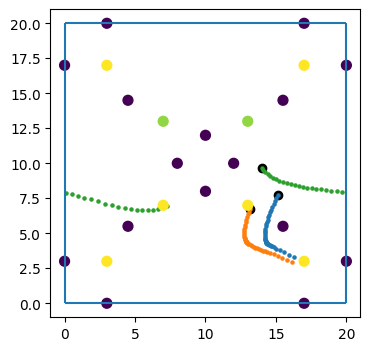

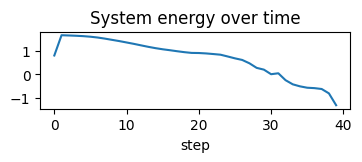

Actual Trajectory


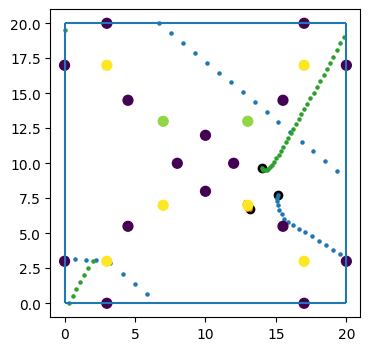

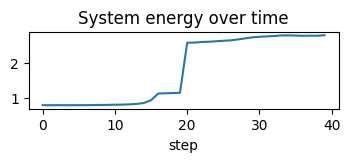

In [76]:
# Load the test trajectoriy
def plot_test_prediction(model, energy_predictor):
    test_index = np.random.randint(900, 1000)
    print(f"Test index: {test_index}")
    trajectory, framework, energy = load_trajectory(f'data/task3/test/trajectory_{test_index}.npz', 'task_3')
    particles = trajectory[0]
    energy_test = energy[0]
    print(f'Particles shape: {particles.shape}, Energy: {energy_test}, Framework shape: {framework.shape}')
    predicted_trajectory, predicted_energy = predict_trajectory_crystal(model, particles, energy_test, framework, time_steps=40, time_step_size=0.5, box_length=20.0, cutoff_value=10.0, energy_predictor=energy_predictor)
    print("Predicted Trajectory")
    plot_trajectory_crystal(predicted_trajectory, framework, predicted_energy)
    print("Actual Trajectory")
    plot_trajectory_crystal(trajectory, framework, energy)

plot_test_prediction(model_task_3, model_task_1)

In [77]:
def compute_mean_losses_trajectory_crystal(model, test_paths, criterion, energy_predictor):
    """
    Compute the mean loss across multiple trajectories.

    Args:
        model (torch.nn.Module): The model used to predict trajectories.
        test_paths (list): List of paths to test trajectories.
        criterion (callable): The loss function to compute the difference between predicted and actual trajectories.

    Returns:
        float: The mean loss over all test trajectories.
    """
    total_loss = 0
    total_loss_linear = 0
    total_loss_constant = 0

    for path in test_paths:
        trajectory, framework, energy = load_trajectory(path, 'task_3')

        particles = trajectory[0]
        energy_test = energy[0]
        predicted_trajectory, _ = predict_trajectory_crystal(model, particles, energy_test, framework, energy_predictor=energy_predictor)
        predicted_trajectory_linear = linear_baseline_predict_trajectory(particles)
        predicted_trajectory_constant = constant_baseline_predict_trajectory(particles)

        loss = compute_loss_trajectory(trajectory, predicted_trajectory, criterion)
        loss_linear = compute_loss_trajectory(trajectory, predicted_trajectory_linear, criterion)
        loss_constant = compute_loss_trajectory(trajectory, predicted_trajectory_constant, criterion)

        total_loss += loss
        total_loss_linear += loss_linear
        total_loss_constant += loss_constant

    return total_loss / len(test_paths), total_loss_linear / len(test_paths), total_loss_constant / len(test_paths)


mean_loss_trajectory, mean_loss_trajectory_linear, mean_loss_trajectory_constant = compute_mean_losses_trajectory_crystal(model_task_3, train_paths_task_3, criterion, model_task_1)
print(f'Mean loss on train set trajectories: {mean_loss_trajectory}')
print(f'Mean loss on train set trajectories (linear baseline): {mean_loss_trajectory_linear}')
print(f'Mean loss on train set trajectories (constant baseline): {mean_loss_trajectory_constant}')

mean_loss_trajectory, mean_loss_trajectory_linear, mean_loss_trajectory_constant = compute_mean_losses_trajectory_crystal(model_task_3, val_paths_task_3, criterion, model_task_1)
print(f'Mean loss on validation set trajectories: {mean_loss_trajectory}')
print(f'Mean loss on validation set trajectories (linear baseline): {mean_loss_trajectory_linear}')
print(f'Mean loss on validation set trajectories (constant baseline): {mean_loss_trajectory_constant}')

mean_loss_trajectory, mean_loss_trajectory_linear, mean_loss_trajectory_constant = compute_mean_losses_trajectory_crystal(model_task_3, test_paths_task_3, criterion, model_task_1)
print(f'Mean loss on test set trajectories: {mean_loss_trajectory}')
print(f'Mean loss on test set trajectories (linear baseline): {mean_loss_trajectory_linear}')
print(f'Mean loss on test set trajectories (constant baseline): {mean_loss_trajectory_constant}')



Mean loss on train set trajectories: 33.19593761629528
Mean loss on train set trajectories (linear baseline): 28.90819050272306
Mean loss on train set trajectories (constant baseline): 24.523806846141817
Mean loss on validation set trajectories: 32.56780973010593
Mean loss on validation set trajectories (linear baseline): 28.478973899947274
Mean loss on validation set trajectories (constant baseline): 23.052248407734766
Mean loss on test set trajectories: 33.82208954811096
Mean loss on test set trajectories (linear baseline): 29.585903549194335
Mean loss on test set trajectories (constant baseline): 25.865797963142395


In [80]:
"""
In chaotic systems, small errors in position predictions can propagate and result in large deviations over time. Consequently, evaluating the model based on positional errors alone may not reflect the true quality of the predictions. Velocity Correlation Analysis offers an alternative approach by focusing on the dynamics of the particles.

Reasons for Choosing Velocity Correlation Analysis:
Captures Dynamic Behavior: Velocities directly reflect the dynamic behavior of particles. A model that correctly predicts velocities is likely capturing the underlying physical dynamics, even if positional errors accumulate over time.
Invariant to Translation: Velocity correlation is invariant to the overall position of the system, making it less sensitive to initial condition errors that propagate in chaotic systems.
Complementary to Positional Metrics: While positional metrics show how far the predicted trajectory is from the true trajectory, velocity correlation shows how well the model captures the motion patterns of the particles.
"""
import numpy as np
from scipy.stats import pearsonr

def velocity_correlation(true_velocities, predicted_velocities):
    correlations = []
    for t in range(true_velocities.shape[1]):
        corr, _ = pearsonr(true_velocities[:, t].flatten(), predicted_velocities[:, t].flatten())
        correlations.append(corr)
    return np.mean(correlations), np.std(correlations)

# Assuming true_velocities and predicted_velocities are numpy arrays of shape (num_particles, num_timesteps, velocity_dim)


def velocity_correlation_analysis(model, test_paths, energy_predictor):
    """
    Perform velocity correlation analysis on the given model using the test trajectories.

    Args:
        model (torch.nn.Module): The model used to predict trajectories.
        test_paths (list): List of paths to test trajectories.
        criterion (callable): The loss function to compute the difference between predicted and actual trajectories.

    Returns:
        float: The mean velocity correlation over all test trajectories.
    """
    total_correlation = 0
    total_std = 0

    for path in test_paths:
        trajectory, framework, energy = load_trajectory(path, 'task_3')

        particles = trajectory[0]
        energy_test = energy[0]
        predicted_trajectory, _ = predict_trajectory_crystal(model, particles, energy_test, framework, energy_predictor=energy_predictor)

        true_velocities = trajectory[:, :, 2:4]
        predicted_velocities = predicted_trajectory[:, :, 2:4]

        mean_corr, std_corr = velocity_correlation(true_velocities, predicted_velocities)
        total_correlation += mean_corr
        total_std += std_corr

    return total_correlation / len(test_paths), total_std / len(test_paths)

mean_velocity_correlation, std_velocity_correlation = velocity_correlation_analysis(model_task_3, train_paths_task_3, model_task_1)
print(f'Mean velocity correlation on train set trajectories: {mean_velocity_correlation}')

mean_velocity_correlation, std_velocity_correlation = velocity_correlation_analysis(model_task_3, val_paths_task_3, model_task_1)
print(f'Mean velocity correlation on validation set trajectories: {mean_velocity_correlation}')

mean_velocity_correlation, std_velocity_correlation = velocity_correlation_analysis(model_task_3, test_paths_task_3, model_task_1)
print(f'Mean velocity correlation on test set trajectories: {mean_velocity_correlation}')
    

Mean velocity correlation on train set trajectories: 0.1778024535922002
Mean velocity correlation on validation set trajectories: 0.15862639671771395
Mean velocity correlation on test set trajectories: 0.1995215863396756
